# DS 7331 Data Mining
### Logistic Regression and SVM
### Mini Lab
* Tahir Ahmad<br>
* Christopher Ballenger<br>
* Grant Bourzikas<br>
* Vitaly Briker<br>

## Introduction
Our business requirement is to identify what features are the most important in predicting if a machine is vulnerable or not. In Mini Lab, Team 4 implemented Logistic Regression (Logit) and Support Vector Machine (SVM) for classification problem of Malware data. The following categories are used for the analysis:

**1) Model Creation**
- Create Logit and SVM model
- Assess how well each model perform (use 80/20 training/testing split)
- Adjust parameters of the models to make them more accurate. For the size of our data (more than 300,000 rows x 80 columsn), stochastic gradient descent (SGD) is used. 

**2) Model Advantages**
- Discuss the advantages of Logit vs SVM 
- Compare model performance in terms of prediction accuracy, training time, and efficiency.

**3) Interpret Feature Importance**
- Use the weights from logistic regression to interpret the importance of different features for the classification task
- Explain the interpretation in detail (why some variables are more important)

**4) Interpet Support Vectors**
- Analyze the chosen support vectors. Explain how SVM vectors provide any insight into the data. Since SGD is used (and therefore did not explicitly solve for support vectors), data must be subsampled to train the SVC model. 



### Notebook Setup

In [1]:
%matplotlib inline

from IPython.display import display
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from math import sqrt
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning

#Show all columns
pd.options.display.max_columns = None

%run -i ColumnArrays.py

### Use Clean Data from Lab1

In [3]:
%time final = pd.read_csv("data/clean.final.csv")

final[cols_categorical] = final[cols_categorical].astype(object)
final[cols_categorical_large] = final[cols_categorical_large].astype(object)
print("Data shape is: ", final.shape)

<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 6.96 s
Data shape is:  (333411, 83)


## MODEL CREATION - Logistic Regression

#### Feature Selections
In Lab 1, exploratory data analysis of Malware data is analyzed extensively. We have became familiar with the different features and chose to split them up for our analysis.  We will first start with features related to the Defender Antivirus on the machines being analyzed.

* **AVProductsInstalled**: Whether AV Products are installed 
* **AVProductsEnabled**: Whether or not the AV is enabled
* **SmartScreen**: This is the SmartScreen enabled string value from registry. This is obtained by checking in order,
* **AVProductStatesIdentifier**: ID for the specific configuration of a user's antivirus software
* **AvSigVersion_x_x**: Defender state information e.g. 1.217
* **AppVersion_x_x**: Defender state information e.g. 4.9
* **EngineVersion**: Defender state information e.g. 1.1.12603.0

#### Exploratory Data Analysis Revisited
The feature **AVProductEnabled** has alomst 96% of its values being the same and will be eliminated from our model.  The 2 remaining features **AVProductsInstalled** and **SmartScreen** does show that different values react differently to the **HasDetection** response variable.  The 2 remaining features have a combined 7 possible values.  In order to use our models, they will transformed to One-Hot Encoding.  

C:\Users\yaniv\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


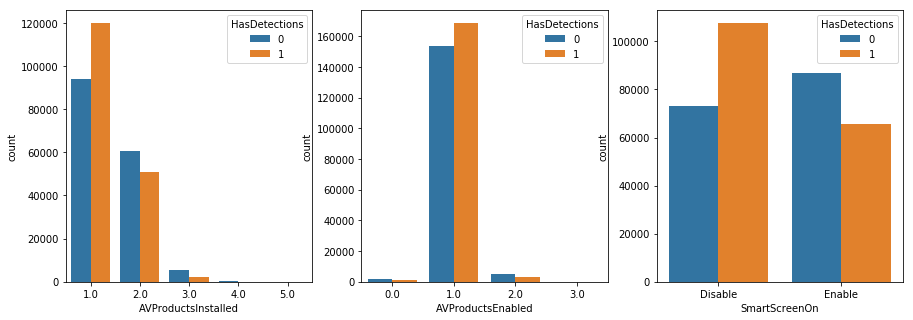

In [4]:
#Modified SmartScreenOn category to two: "Enable" for "Block", "Prompt", "RequireAdmin", and "Warn". Else is "Disable"
final["SmartScreenOn"] = final.SmartScreen
final.SmartScreenOn.replace(
    {
        "Block":"Enable",
        "ExistsNotSet":"Disable",
        "Off" :"Disable",
        "Prompt" :"Enable",
        "RequireAdmin":"Enable",
        "Warn":"Enable"
    },inplace=True)

#Splitting AppVersion, AvSigVersion to Major Revision Only
AppVersion_split = final["AppVersion"].str.rsplit(pat=".",expand=True)
final["AppVersion_x_x"] = AppVersion_split.loc[:,0]+"."+AppVersion_split.loc[:,1]#+"."+AppVersion_split.loc[:,2]

AvSigVersion_split = final["AvSigVersion"].str.rsplit(pat=".",expand=True)
final["AvSigVersion_x_x"] = AvSigVersion_split.loc[:,0]+"."+AvSigVersion_split.loc[:,1]
final["AvSigVersion_x_x_x"] = AvSigVersion_split.loc[:,0]+"."+AvSigVersion_split.loc[:,1]+"."+AvSigVersion_split.loc[:,2].str[:2]

fig, ax =plt.subplots(1,3,figsize=(15,5))
i = sns.countplot(x="AVProductsInstalled", hue="HasDetections", data=final, ax=ax[0], )
e = sns.countplot(x="AVProductsEnabled", hue="HasDetections",data=final, ax=ax[1] )
s = sns.countplot(x="SmartScreenOn",hue="HasDetections",data=final, ax=ax[2])
fig.show()

Since we will be using the 3 different versions to help understand how Defender plays a role in Malware detections, we wanted to check for correlations between different builds.  The below heatmap shows us that **EngineVersion** is highly correlated with **AVSigVersion**.  Through our reserch, we learned that **AVSigVersion** has the latest versions of malware definitions.  In order to explain our features, we will eliminate **EngineVersion** in favor of **AVSigVersion** for our model.  The features will also be transformed using One-Hot Encoding, resulting 51 new features.

The final feature **AVProductStatesIdentifier** has 2960 possible values.  We will leave this in our model given it explains additional user settings in Denfender. 

#### One-Hot Encoding using "get_dummies"

In [5]:
Response = final[["HasDetections", "MachineIdentifier"]]
print("Response Shape is", Response.shape)

EngineVersion = pd.get_dummies(final["EngineVersion"],prefix="EngineVersion")
RtpStateBitfield = pd.get_dummies(final["RtpStateBitfield"],prefix="RtpStateBitfield")
AVProductsInstalled = pd.get_dummies(final["AVProductsInstalled"],prefix="AVProductsInstalled")
AVProductsEnabled = pd.get_dummies(final["AVProductsEnabled"],prefix="AVProductsEnabled")
OrganizationIdentifier = pd.get_dummies(final["OrganizationIdentifier"],prefix="OrganizationIdentifier")
Platform = pd.get_dummies(final["Platform"],prefix="Platform")
Processor = pd.get_dummies(final["Processor"],prefix="Processor")
OsVer = pd.get_dummies(final["OsVer"],prefix="OsVer")
OsBuild = pd.get_dummies(final["OsBuild"],prefix="OsBuild")
OsSuite = pd.get_dummies(final["OsSuite"],prefix="OsSuite")
OsPlatformSubRelease = pd.get_dummies(final["OsPlatformSubRelease"],prefix="OsPlatformSubRelease")
SkuEdition = pd.get_dummies(final["SkuEdition"],prefix="SkuEdition")
SmartScreen = pd.get_dummies(final["SmartScreen"],prefix="SmartScreen")
Census_MDC2FormFactor = pd.get_dummies(final["Census_MDC2FormFactor"],prefix="Census_MDC2FormFactor")
Census_ProcessorManufacturerIdentifier = pd.get_dummies(final["Census_ProcessorManufacturerIdentifier"],prefix="Census_ProcessorManufacturerIdentifier")
Census_PrimaryDiskTypeName = pd.get_dummies(final["Census_PrimaryDiskTypeName"],prefix="Census_PrimaryDiskTypeName")
Census_ChassisTypeName = pd.get_dummies(final["Census_ChassisTypeName"],prefix="Census_ChassisTypeName")
Census_PowerPlatformRoleName = pd.get_dummies(final["Census_PowerPlatformRoleName"],prefix="Census_PowerPlatformRoleName")
Census_OSArchitecture = pd.get_dummies(final["Census_OSArchitecture"],prefix="Census_OSArchitecture")
Census_OSBranch = pd.get_dummies(final["Census_OSBranch"],prefix="Census_OSBranch")
Census_OSBuildNumber = pd.get_dummies(final["Census_OSBuildNumber"],prefix="Census_OSBuildNumber")
Census_OSEdition = pd.get_dummies(final["Census_OSEdition"],prefix="Census_OSEdition")
Census_OSSkuName = pd.get_dummies(final["Census_OSSkuName"],prefix="Census_OSSkuName")
Census_OSInstallTypeName = pd.get_dummies(final["Census_OSInstallTypeName"],prefix="Census_OSInstallTypeName")
Census_OSInstallLanguageIdentifier = pd.get_dummies(final["Census_OSInstallLanguageIdentifier"],prefix="Census_OSInstallLanguageIdentifier")
Census_OSUILocaleIdentifier = pd.get_dummies(final["Census_OSUILocaleIdentifier"],prefix="Census_OSUILocaleIdentifier")
Census_OSWUAutoUpdateOptionsName = pd.get_dummies(final["Census_OSWUAutoUpdateOptionsName"],prefix="Census_OSWUAutoUpdateOptionsName")
Census_GenuineStateName = pd.get_dummies(final["Census_GenuineStateName"],prefix="Census_GenuineStateName")
Census_ActivationChannel = pd.get_dummies(final["Census_ActivationChannel"],prefix="Census_ActivationChannel")
Census_FlightRing = pd.get_dummies(final["Census_FlightRing"],prefix="Census_FlightRing")
Wdft_RegionIdentifier = pd.get_dummies(final["Wdft_RegionIdentifier"],prefix="Wdft_RegionIdentifier")

AppVersion = pd.get_dummies(final["AppVersion"],prefix="AppVersion")
AvSigVersion = pd.get_dummies(final["AvSigVersion"],prefix="AvSigVersion")
AVProductStatesIdentifier  = pd.get_dummies(final["AVProductStatesIdentifier"],prefix="AVProductStatesIdentifier")

AppVersion_x_x = pd.get_dummies(final["AppVersion_x_x"],prefix="AppVersion_x_x")
AvSigVersion_x_x = pd.get_dummies(final["AvSigVersion_x_x"],prefix="AvSigVersion_x_x")
AvSigVersion_x_x_x  = pd.get_dummies(final["AvSigVersion_x_x_x"],prefix="AvSigVersion_x_x_x")  

Response Shape is (333411, 2)


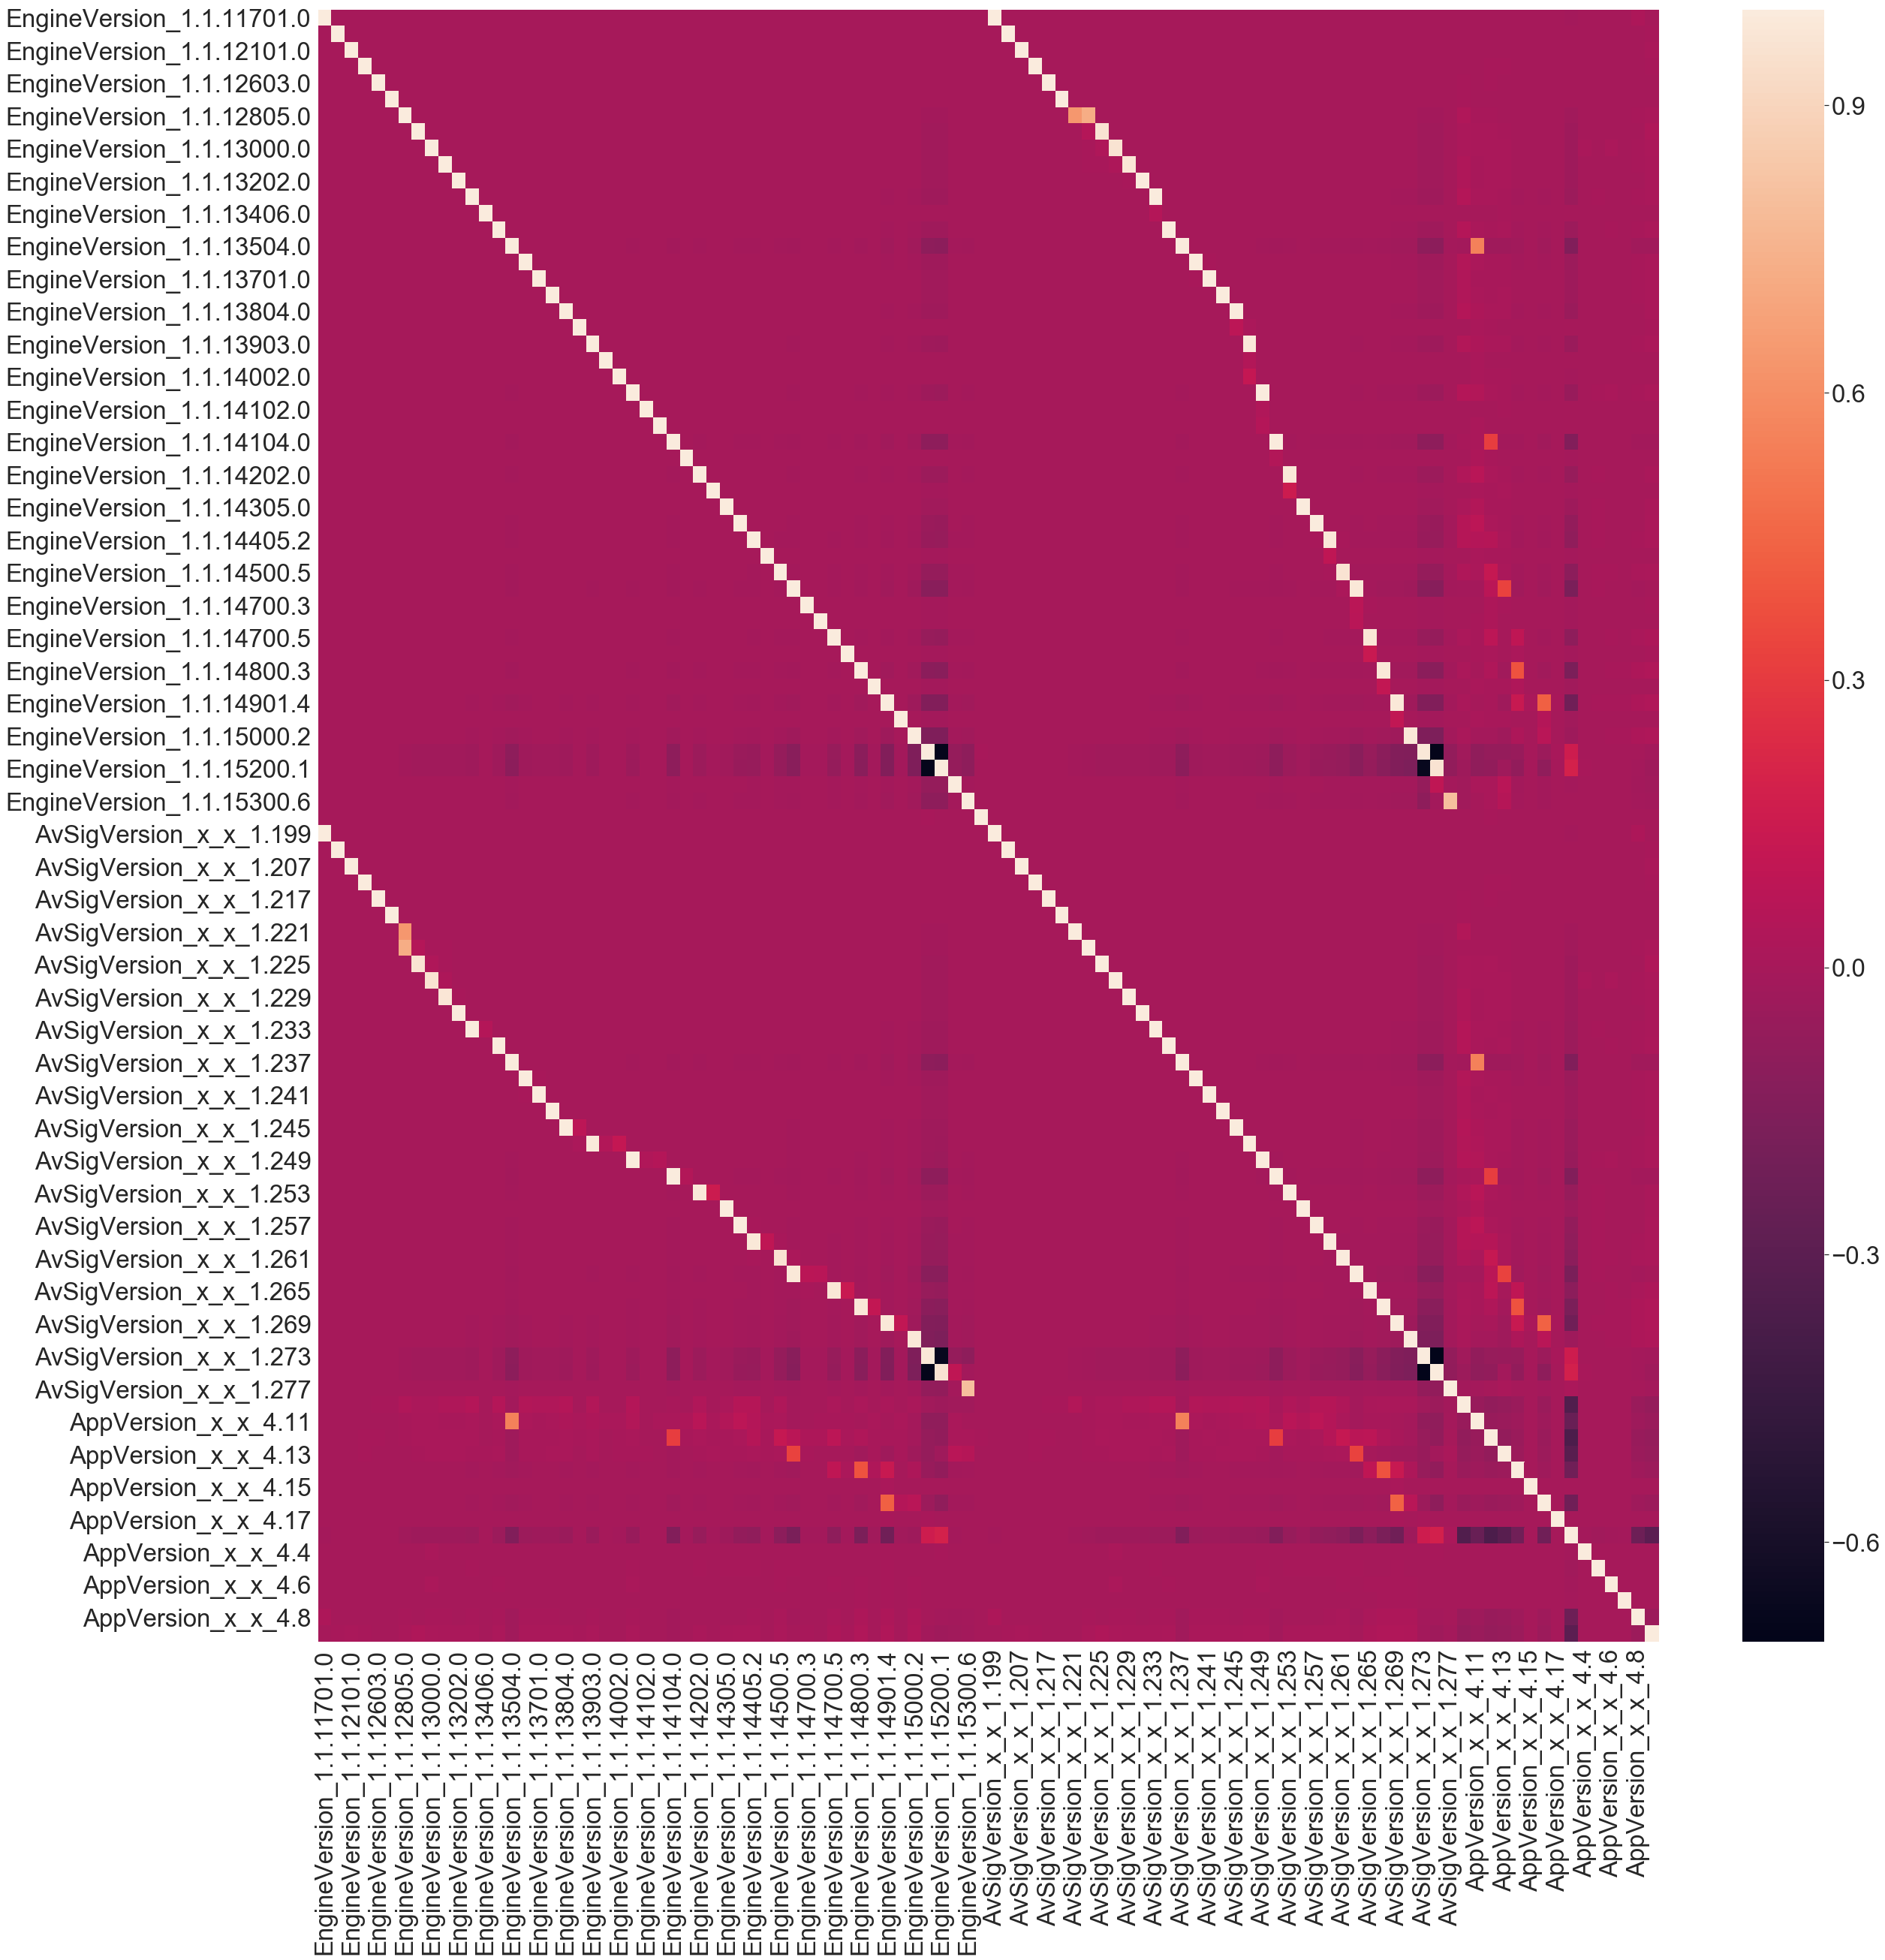

In [5]:
av_builds = pd.concat(
    (
        EngineVersion,
        AvSigVersion_x_x,
        AppVersion_x_x
    ), axis=1
)

sns.set(font_scale=3)
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(av_builds.corr(), ax=ax)
plt.show()

#### Initial Model
In order to build our model and identify the best features, we will split the data between 80/20, with 20% being our test set.  Our final modle will be validated using a 3-fold Cross Validation.  Our Logistic Regression model will start with a cost of 1, but may by adjusted as we learn more about our model.
We initiated our model by building it using the following features:
- AVProductStatesIdentifier,
- AVProductsInstalled,
- SmartScreen,
- AvSigVersion_x_x,
- AppVersion_x_x

In [6]:
cols = ["IsProtected","firewall"]

df = pd.concat(
    (
        AVProductStatesIdentifier,
        AVProductsInstalled,
        SmartScreen,
        AvSigVersion_x_x,
        AppVersion_x_x
    ),axis=1)

print("Initial Model Shape is", df.shape)

Initial Model Shape is (333411, 3022)


In [7]:
X = df.values
y = final["HasDetections"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Instantiate our model
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Train the model
%time lr_clf.fit(X_train,y_train)
# Get our estimates
y_hat = lr_clf.predict(X_test)

# Metrics
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
auc = mt.roc_auc_score(y_test, y_hat)

print(X_train.shape, " ", X_test.shape)
print("accuracy", acc )
print("confusion matrix\n",conf)
print("area under the curve\n",auc)
print(mt.classification_report(y_test,y_hat))

CPU times: user 8.55 s, sys: 5.57 s, total: 14.1 s
Wall time: 13.8 s
(266728, 3022)   (66683, 3022)
accuracy 0.6046368639683277
confusion matrix
 [[18048 13840]
 [12524 22271]]
area under the curve
 0.6030220803708223
             precision    recall  f1-score   support

          0       0.59      0.57      0.58     31888
          1       0.62      0.64      0.63     34795

avg / total       0.60      0.60      0.60     66683



For our initial model we attain an accuracy score of 0.605 and an area under the curve score of 0.603. Interestingly, we can see the precision for Malware detection can be as high as 0.62. We believe we can improve our accuracy by adding additional features about a user's machine.

### Adding Census Features
With our low accuracy and poor sensisivity score, we want to see if we can improve our model by adding in Machine Features.

##### Categorical Features
* **Census_MDC2FormFactor**: A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
* **Census_OSSkuName**: OS edition friendly name (currently Windows only)
* **Census_GenuineStateName**: Friendly name of OSGenuineStateID. 0 = Genuine
* **Census_ActivationChannel**: Retail license key or Volume license key for a machine.

##### Continous Features
* **Census_ProcessorCoreCount**: Number of logical cores in the processor
* **Census_PrimaryDiskTotalCapacity**: Amount of disk space on primary disk of the machine in MB (Log Transformation).
* **Census_SystemVolumeTotalCapacity**: The size of the partition that the System volume is installed on in MB (Log Transformation).
* **Census_TotalPhysicalRAM**: The size of the partition that the System volume is installed on in MB (Log Transformation)
* **Census_InternalPrimaryDiagonalDisplaySizeInInches**: Retrieves the physical diagonal length in inches of the primary display
* **Census_InternalPrimaryDisplayResolutionHorizontal**: Retrieves the number of pixels in the horizontal direction of the internal display.
* **Census_InternalPrimaryDisplayResolutionVertical**: Retrieves the number of pixels in the vertical direction of the internal display

After log transformatio, are continous variables has normal distribution.  For our next test, we will include these features as they are provided and another test after normalizing the continous features.

### Analyzing Census data: FormFactor, OSSkuName, GenuineStateName, ActivationChannel

From below data, we can see that these 4 features have distinct comparison between Malware detection.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


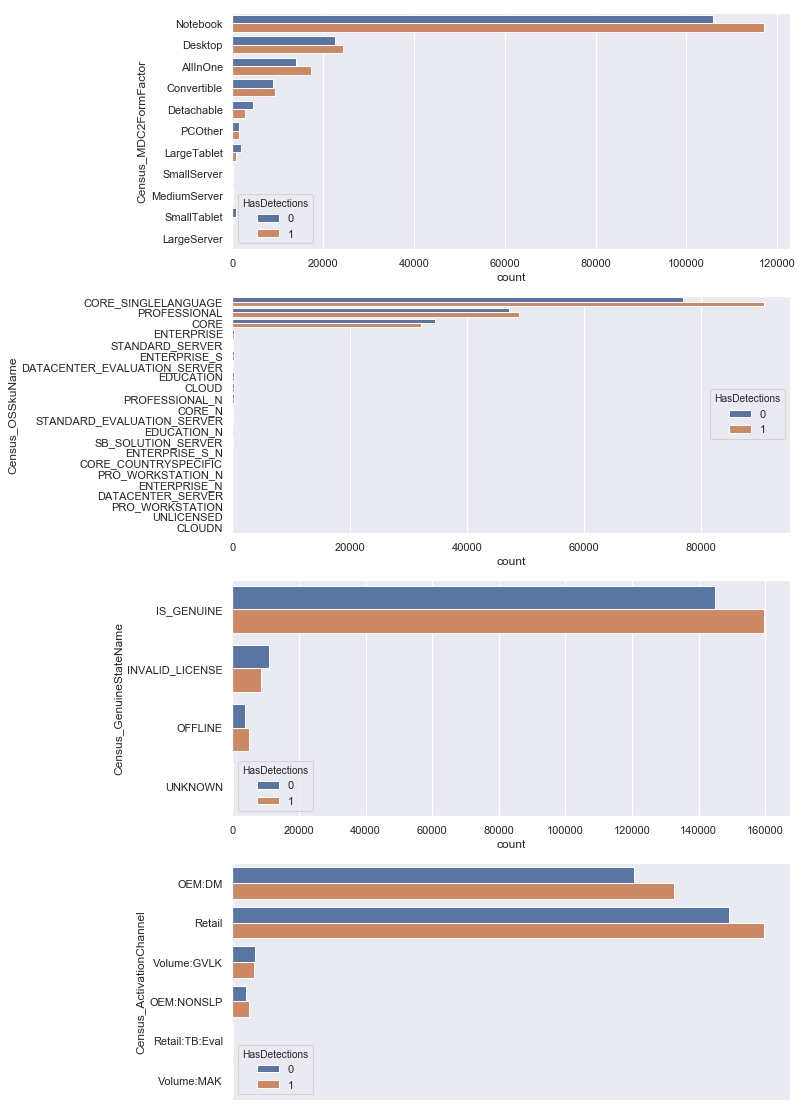

In [10]:
sns.set(font_scale=1)
fig, ax =plt.subplots(4,1,figsize=(10,20))
m = sns.countplot(y="Census_MDC2FormFactor", hue="HasDetections", data=final, ax=ax[0], orient="h" )
o = sns.countplot(y="Census_OSSkuName", hue="HasDetections",data=final, ax=ax[1], orient="h" )
g = sns.countplot(y="Census_GenuineStateName",hue="HasDetections",data=final, ax=ax[2],orient="h")
a = sns.countplot(y="Census_ActivationChannel",hue="HasDetections",data=final, ax=ax[3],orient="h")
a.set_xticks([])
a.set_xlabel('')
fig.show()

#### Continuous Data

In [8]:
df1 = pd.concat(
    (
        df,
        Census_MDC2FormFactor,
        Census_OSSkuName,
        Census_GenuineStateName,
        Census_ActivationChannel
    ),axis=1)

df_continous = final[cols_numerical].copy()
df_continous["Census_SystemVolumeTotalCapacity"] = np.log(df_continous.Census_SystemVolumeTotalCapacity)
df_continous["Census_TotalPhysicalRAM"] = np.log(df_continous.Census_TotalPhysicalRAM)
df_continous["Census_PrimaryDiskTotalCapacity"] = np.log(df_continous.Census_PrimaryDiskTotalCapacity)

df_continous.describe()

Census_ProcessorCoreCount  Census_PrimaryDiskTotalCapacity  \
count              333411.000000                    333411.000000   
mean                    3.195485                        12.962932   
std                     1.568252                         0.932306   
min                     1.000000                         9.232787   
25%                     2.000000                        12.628870   
50%                     4.000000                        13.075146   
75%                     4.000000                        13.768282   
max                    64.000000                        16.658639   

       Census_SystemVolumeTotalCapacity  Census_TotalPhysicalRAM  \
count                     333411.000000            333411.000000   
mean                          12.874873                 8.404741   
std                            0.957852                 0.561339   
min                            9.177404                 6.238325   
25%                           12.579507                 8.317766   
50%                           13.046954                 8.317766   
75%                           13.739700                 9.010913   
max                           16.658604                13.575262   

       Census_InternalPrimaryDiagonalDisplaySizeInInches  \
count                                      333411.000000   
mean                                           15.860255   
std                                             4.964178   
min                                             5.500000   
25%                                            13.900000   
50%                                            15.500000   
75%                                            15.600000   
max                                           142.000000   

       Census_InternalPrimaryDisplayResolutionHorizontal  \
count                                      333411.000000   
mean                                         1436.107384   
std                                           250.134264   
min                                           320.000000   
25%                                          1366.000000   
50%                                          1366.000000   
75%                                          1366.000000   
max                                          6016.000000   

       Census_InternalPrimaryDisplayResolutionVertical  
count                                    333411.000000  
mean                                        827.462102  
std                                         144.373430  
min                                         240.000000  
25%                                         768.000000  
50%                                         768.000000  
75%                                         800.000000  
max                                        3840.000000

### Model with Census Features
From our EDA, we know that **Census_MDC2FormFactor** can be a replacement for the contionus hardware configurations. In order to determine if this model can help us, we will build 3 models to compare.  Census Categories, Categories w/ Continous, and Cateogiries w/ normalized continous.

##### Without Continuous

In [10]:
logit_acc = []
logit_conf = []
logit_auc = []

X = df1.values
# x2 = df_continous.values
y = final["HasDetections"].values

#Join categorical and continous variables
#X = np.append(x1,x2,axis=1)
x_labels = np.append(df1.columns, df_continous.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Instantiate our model
final_lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Train the model
%time final_lr_clf.fit(X_train,y_train)
# Get our estimates
y_hat = final_lr_clf.predict(X_test)

# Metrics
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
auc = mt.roc_auc_score(y_test, y_hat)

print(X_train.shape, " ", X_test.shape)
print("accuracy", acc )
print("confusion matrix\n",conf)
print("area under the curve\n",auc)

logit_acc.append(acc)
logit_conf.append(conf)
logit_auc.append(auc)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 12.5 s, sys: 11.9 s, total: 24.4 s
Wall time: 25.8 s
(266728, 3065)   (66683, 3065)
accuracy 0.6155241965718399
confusion matrix
 [[16779 15109]
 [10529 24266]]
area under the curve
 0.6117922252420042


#### Model including Continuous Features

In [29]:
x1 = df1.values
x2 = df_continous.values
y = final["HasDetections"].values

#Join categorical and continous variables
X = np.append(x1,x2,axis=1)
x_labels = np.append(df1.columns, df_continous.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Instantiate our model
final_lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Train the model
%time final_lr_clf.fit(X_train,y_train)
# Get our estimates
y_hat = final_lr_clf.predict(X_test)

# Metrics
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
auc = mt.roc_auc_score(y_test, y_hat)

print(X_train.shape, " ", X_test.shape)
print("accuracy", acc )
print("confusion matrix\n",conf)
print("area under the curve\n",auc)

logit_acc.append(acc)
logit_conf.append(conf)
logit_auc.append(auc)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 10.8 s, sys: 7.43 s, total: 18.2 s
Wall time: 19.4 s
(266728, 3072)   (66683, 3072)
accuracy 0.6178036381086633
confusion matrix
 [[17153 14735]
 [10751 24044]]
area under the curve
 0.6144663866823147


##### Normalize Continuous Variables

In [34]:
x1 = df1.values
y = final["HasDetections"].values

# Split the first set, using random_state=123 to make sure both X1 and X2 and random
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.20, random_state=123)

x2 = df_continous.values
norm = Normalizer()

x2_train, x2_test, y_train, y_test = train_test_split(x2, y, test_size=0.20, random_state=123)
norm.fit(x2_train)
x2_train = norm.transform(x2_train)
x2_test = norm.transform(x2_test)

#Combine X train and X test
X_train = np.append(x1_train,x2_train,axis=1)
X_test = np.append(x1_test,x2_test,axis=1)

# Instantiate our model
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Train the model
%time lr_clf.fit(X_train,y_train)
# Get our estimates
y_hat = lr_clf.predict(X_test)

# Metrics
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
auc = mt.roc_auc_score(y_test, y_hat)

print(X_train.shape, " ", X_test.shape)
print("accuracy", acc )
print("confusion matrix\n",conf)
print("area under the curve\n",auc)

logit_acc.append(acc)
logit_conf.append(conf)
logit_auc.append(auc)

CPU times: user 16.7 s, sys: 2.86 s, total: 19.6 s
Wall time: 19.4 s
(266728, 3072)   (66683, 3072)
accuracy 0.6156591635049413
confusion matrix
 [[16896 14992]
 [10637 24158]]
area under the curve
 0.6120748240338527


NameError: name 'logit_acc' is not defined

In [31]:
display( pd.DataFrame({
    "model":["1) without continuous","2) with continuous","3) normalize continuous"],
    "accracy":logit_acc,
    "area_under_curve":auc}) )


model   accracy  area_under_curve
0    1) without continuous  0.615524          0.612075
1       2) with continuous  0.617804          0.612075
2  3) normalize continuous  0.615659          0.612075

From all 3 models, the model with continuous performs the best with an accuracy of 0.617.  We do have the same AUC in all 3 models.  Since the response variable of **HasDetections** is balanced, we chose to measure by accuracy.

### Parameter Optimization with Cost
To determine if we can improve our model, we tested our model by changing the cost value ranging from 0.001 to 10.  From our cost analysis using the same training/test set in previous models, we have found that the **cost of 1** produced the best accuracy.

In [9]:
x1 = df1.values
x2 = df_continous.values
y = final["HasDetections"].values

#Join categorical and continous variables
X = np.append(x1,x2,axis=1)

# here we can change some of the parameters interactively
from sklearn.model_selection import cross_val_score
cv_object = ShuffleSplit(
    n_splits=1,
    test_size  = 0.2,
    random_state = 123
)
def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    return cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

for c in (0.001, 0.01,0.1,0.5,1,2,10):
    print("Cost Paramater " + str(c), lr_explor(cost=c) )
    

Cost Paramater 0.001 [0.61014052]
Cost Paramater 0.01 [0.61540423]
Cost Paramater 0.1 [0.61690386]
Cost Paramater 0.5 [0.61760869]
Cost Paramater 1 [0.61780364]
Cost Paramater 2 [0.61736874]
Cost Paramater 10 [0.61576414]


In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import roc_curve, auc

def getSummaryMetrics(test, yhat, shortDesc, iter_num = 0):
    print('\n' + shortDesc + '\n')
    conf = mt.confusion_matrix(test,yhat)
    acc = mt.accuracy_score(test,yhat)
    rocauc = mt.roc_auc_score(test,yhat)    
    cm = mt.classification_report(test,yhat)
    mae = mt.mean_absolute_error(test,yhat)
    cfraw = mt.confusion_matrix(y_test,yhat)

    print('Confusion Matrix Raw:\n',cfraw)
    print('Confusion Matrix:\n',cm)
    print('AUC:',rocauc)
    print('MAE:', mae)
    print('Accuracy:', acc)
    rmse = sqrt(mean_squared_error(test,yhat))
    print('RMSE: ', rmse)

    fpr, tpr, thresholds = roc_curve(test,yhat)
    roc_auc = auc(fpr, tpr)
    
#     df = pd.DataFrame(
    df = {
            "shortDesc":shortDesc,
            "test_num":iter_num,
            "rocauc":rocauc,
            "mae":mae,
            "accuracy":acc,
            "rmse":rmse
        }
#     )
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return df
    
test_result = []

### Final Model Logit with 3-fold Cross Validation

CPU times: user 12.7 s, sys: 3.16 s, total: 15.9 s
Wall time: 16.1 s

Logistic Model

Confusion Matrix Raw:
 [[17106 15023]
 [10361 24193]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.62      0.53      0.57     32129
          1       0.62      0.70      0.66     34554

avg / total       0.62      0.62      0.62     66683

AUC: 0.6162833431472792
MAE: 0.3806667366495209
Accuracy: 0.6193332633504791
RMSE:  0.616981958123186


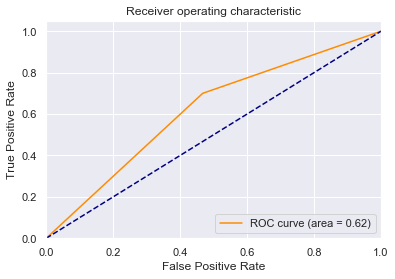

CPU times: user 14.1 s, sys: 3.11 s, total: 17.2 s
Wall time: 17.4 s

Logistic Model

Confusion Matrix Raw:
 [[17081 14902]
 [10463 24237]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.62      0.53      0.57     31983
          1       0.62      0.70      0.66     34700

avg / total       0.62      0.62      0.62     66683

AUC: 0.6162687972473849
MAE: 0.3803818064574179
Accuracy: 0.6196181935425821
RMSE:  0.6167510084770174


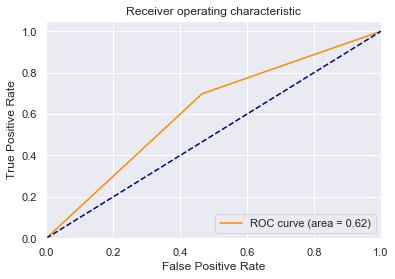

CPU times: user 11.1 s, sys: 3.12 s, total: 14.2 s
Wall time: 14.4 s

Logistic Model

Confusion Matrix Raw:
 [[17208 14880]
 [10472 24123]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.62      0.54      0.58     32088
          1       0.62      0.70      0.66     34595

avg / total       0.62      0.62      0.62     66683

AUC: 0.6167862701894116
MAE: 0.3801868542207159
Accuracy: 0.619813145779284
RMSE:  0.6165929404564375


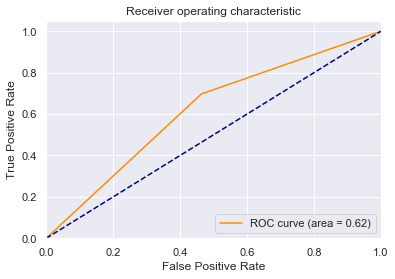

[{'shortDesc': 'Logistic Model',
  'test_num': 0,
  'rocauc': 0.6162833431472792,
  'mae': 0.3806667366495209,
  'accuracy': 0.6193332633504791,
  'rsme': 0.616981958123186},
 {'shortDesc': 'Logistic Model',
  'test_num': 1,
  'rocauc': 0.6162687972473849,
  'mae': 0.3803818064574179,
  'accuracy': 0.6196181935425821,
  'rsme': 0.6167510084770174},
 {'shortDesc': 'Logistic Model',
  'test_num': 2,
  'rocauc': 0.6167862701894116,
  'mae': 0.3801868542207159,
  'accuracy': 0.619813145779284,
  'rsme': 0.6165929404564375}]

In [25]:
x1 = df1.values
x2 = df_continous.values
y = final["HasDetections"].values

X = np.append(x1,x2,axis=1)

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
    n_splits=num_cv_iterations,
    test_size  = 0.2
)

# first we create a reusable logisitic regression object
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

iter_num=1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    %time lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    result = getSummaryMetrics(y_test,y_hat, "Logistic Model", iter_num)
    test_result.append(result)
    iter_num+=1

display(test_result)

**Logistic Regression Conclusion** Our final model had an average accuracy score of 0.619 and consistent RMSE score for each Cross Validaiton.  We believe our model is not overfitted.

On our last model we had a precision score of 0.62 for Machines we identify as having malware (HasDections) and machines we faslely dected has having malware.  In order to improve our AUC, we need to increase accuracy rate, by not increasing the false positive.


## Support Vector Machine using Stochastic Gradient Descent

The following code utilizes stochastic gradient descent (SGD) learning because the team was not able to utilize the traditional Bulk Support Vector Machine (SVM) due to the length of the training and testing of the model.  Utilizing the traditional SVM model, the models ran over 18 hours, on a standard MacBook, and never completed. To address this issues, the team used stochastic gradient descent which estimates each sample for the model and updating it. Additionaly, as compared to SVG, SGD allows minibatch learning to determine a partial fit method.

To begin SVM analysis, the team selected the best model from the logistric tregression model above, which had an accuracy of 62%, and applied multiple models SVM with SGD.

In [26]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from math import sqrt

In the following model, the team set the learning rate as "Optimal" to ensure it has the best speed and the Loss set to "Hinge" which uses linear Support Vector Machines. This model did not use the scaler, as the logistic regression model above did because the team wanted to understand how the exact model would perform using SGD with (soft-margin) linear SVM.

In [40]:
x1 = df1.values
x2 = df_continous.values
y = final["HasDetections"].values

X = np.append(x1,x2,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

svm_test_result = []

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 40.3 µs

Hinge without Scaler SGD

Confusion Matrix Raw:
 [[  952 30936]
 [  460 34335]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.67      0.03      0.06     31888
          1       0.53      0.99      0.69     34795

avg / total       0.60      0.53      0.39     66683

AUC: 0.5083171002229603
MAE: 0.4708246479612495
Accuracy: 0.5291753520387505
RMSE:  0.6861666327950154


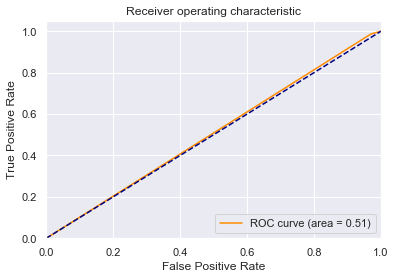

In [41]:
## New Try without Scaler
%time
# use some compact notation for creating a linear SVM classifier with stichastic descent

regularize_const = 0.1

svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_jobs=-1, penalty='l2')

svm_sgd.fit(X_train, y_train)
yhat = svm_sgd.predict(X_test)

result = getSummaryMetrics(y_test, yhat, "Hinge without Scaler SGD")
svm_test_result.append(result)

As you can tell from the model, a ~52% accuracy score is signficnatly worse than the Logistric Regresssion model (62%). The confusion matrix and AUC value (50.8%) suggest that this models is not much better than random guess. For the next model, the team used the same SVG using SGD but this time the team used the standards scaler. 


Hinge with Scaler SGD

Confusion Matrix Raw:
 [[14195 17693]
 [ 8174 26621]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.63      0.45      0.52     31888
          1       0.60      0.77      0.67     34795

avg / total       0.62      0.61      0.60     66683

AUC: 0.6051164855302223
MAE: 0.38790996205929545
Accuracy: 0.6120900379407045
RMSE:  0.62282418230131


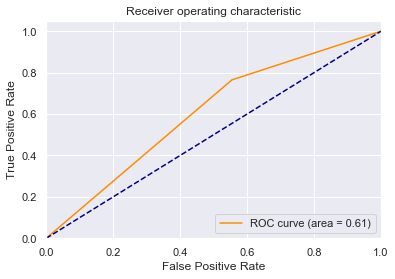

In [42]:
iterations=10

sqHinge_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_jobs=-1, penalty='l2')

cv = StratifiedShuffleSplit( n_splits=3,test_size=0.2)

scl = StandardScaler()
# for train_idx, test_idx in cv.split(X,y):
sqHinge_sgd.fit(scl.fit_transform(X_train),y_train)
yhat = sqHinge_sgd.predict(scl.transform(X_test))
                           
result = getSummaryMetrics(y_test, yhat, "Hinge with Scaler SGD")
svm_test_result.append(result)

As noted from the accuracy scores above, the model performed signifanctly better with the standard scaler as compared without the scaler. The AUC for this model performed ~10% better than the model without scaler. As expected, the RMSE has dropped, ~6% which would imply better prediction than the previous model without scaler.

For the next model, the team set the learning rate as "Optimal" to ensure it has the best speed to and the Loss set to "Log" which uses logistic regression with SGD.


Logistic Regression SGD

Confusion Matrix Raw:
 [[12526 19362]
 [13817 20978]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.48      0.39      0.43     31888
          1       0.52      0.60      0.56     34795

avg / total       0.50      0.50      0.50     66683

AUC: 0.49785752955433105
MAE: 0.4975630970412249
Accuracy: 0.5024369029587751
RMSE:  0.7053815258717973


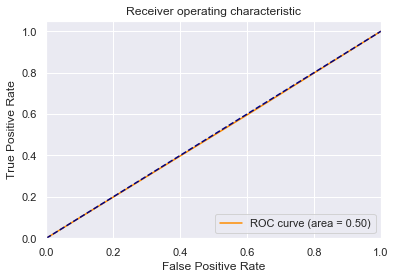

CPU times: user 1min 9s, sys: 1min 24s, total: 2min 34s
Wall time: 1min 39s


In [43]:
%%time
iterations=10

# use some compact notation for creating a logistic regression classifier with stochastic descent
sqHinge_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

cv = StratifiedShuffleSplit( n_splits=5,test_size=0.2)

scl = StandardScaler()
# for train_idx, test_idx in cv.split(X,y):
sqHinge_sgd.fit(scl.fit_transform(X_train),y_train)
yhat = sqHinge_sgd.predict(scl.transform(X[test_idx]))
result = getSummaryMetrics(y_test, yhat, "Logistic Regression SGD")
svm_test_result.append(result)

Utilizing the logistic regression in SGD model the accuracy drops to 50% with an RMSE of 70% suggest this model is also not better than random guess.

For the next model, the team set the learning rate as "Optimal" to ensure it has the best speed to and the Loss set to "Square_Hinge" which is like Hinge but is quadratically penalized.



Squared Hinge SGD

Confusion Matrix Raw:
 [[16441 15447]
 [13342 21453]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.55      0.52      0.53     31888
          1       0.58      0.62      0.60     34795

avg / total       0.57      0.57      0.57     66683

AUC: 0.566069951451001
MAE: 0.4317292263395468
Accuracy: 0.5682707736604532
RMSE:  0.6570610522162661


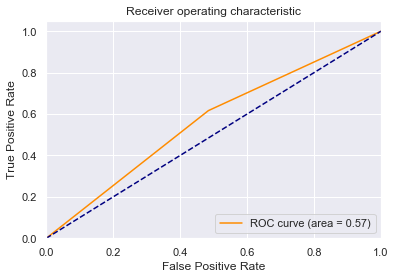

In [44]:
iterations=10

# use some compact notation for creating a logistic regression classifier with stochastic descent
sqHinge_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='squared_hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

cv = StratifiedShuffleSplit( n_splits=3,test_size=0.2)

scl = StandardScaler()
# for train_idx, test_idx in cv.split(X,y):
sqHinge_sgd.fit(scl.fit_transform(X_train),y_train)
yhat = sqHinge_sgd.predict(scl.transform(X_test))
result = getSummaryMetrics(y_test, yhat, "Squared Hinge SGD")
svm_test_result.append(result)
    

The squared hinge method did not have as high accuracy, on the average of 57% beause of the quadratic penality in he model. Also, the RMSE increases by 3%.

The next step was to reduce the dimensionality of the dataset utilizing the PCA logistic regression SGD models.


PCA Dimensionality

Confusion Matrix Raw:
 [[19417 12471]
 [15235 19560]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.56      0.61      0.58     31888
          1       0.61      0.56      0.59     34795

avg / total       0.59      0.58      0.58     66683

AUC: 0.58553108885482
MAE: 0.4154882053896795
Accuracy: 0.5845117946103204
RMSE:  0.6445837458311212


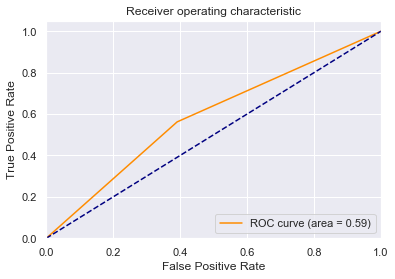

CPU times: user 2min 1s, sys: 52.5 s, total: 2min 53s
Wall time: 1min 18s


In [45]:
%%time
from sklearn.decomposition import PCA
n_components = 50

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
# for train_idx, test_idx in cv.split(X,y):
log_sgd.fit(pca.fit_transform(X_train),y_train)
yhat = log_sgd.predict(pca.transform(X_test))
result = getSummaryMetrics(y_test,yhat, "PCA Dimensionality")
svm_test_result.append(result)

Using PCA in SGD model did not produce high accuracy, on the average of 58%. The score was still ~4% below the teams logistic regression model and ~1% below the top SGD model. 

With SGD classifier, our **best model is with linear SVM and standard scaling**. Please see below the summary of the performance.

In [46]:
display(pd.DataFrame(svm_test_result))

accuracy       mae    rocauc      rsme                 shortDesc  test_num
0  0.529175  0.470825  0.508317  0.686167  Hinge without Scaler SGD         0
1  0.612090  0.387910  0.605116  0.622824     Hinge with Scaler SGD         0
2  0.502437  0.497563  0.497858  0.705382   Logistic Regression SGD         0
3  0.568271  0.431729  0.566070  0.657061         Squared Hinge SGD         0
4  0.584512  0.415488  0.585531  0.644584        PCA Dimensionality         0

We have chosen "Hinge with Scaler SGD" as our final model due to consistent performance.  Below we tested our model using 3-folds, 80-20 split.


Hinge with Scaler SGD

Confusion Matrix Raw:
 [[10761 21127]
 [11620 23175]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.64      0.45      0.53     32030
          1       0.60      0.77      0.67     34653

avg / total       0.62      0.61      0.60     66683

AUC: 0.6079510938107678
MAE: 0.38575049112967325
Accuracy: 0.6142495088703268
RMSE:  0.6210881508527378


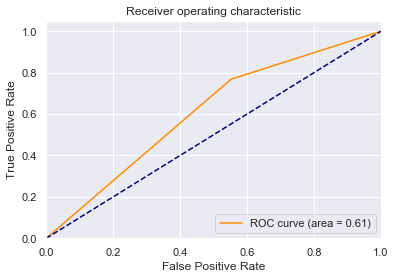


Hinge with Scaler SGD

Confusion Matrix Raw:
 [[10846 21042]
 [11676 23119]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.63      0.44      0.52     32030
          1       0.60      0.76      0.67     34653

avg / total       0.61      0.61      0.60     66683

AUC: 0.6024020596546508
MAE: 0.39137411334223116
Accuracy: 0.6086258866577688
RMSE:  0.6255990036295064


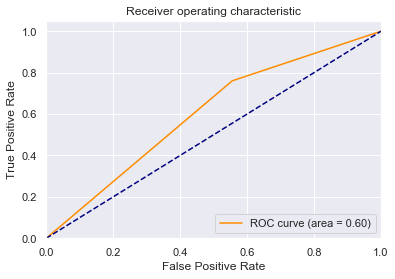


Hinge with Scaler SGD

Confusion Matrix Raw:
 [[10834 21054]
 [11573 23222]]
Confusion Matrix:
              precision    recall  f1-score   support

          0       0.64      0.45      0.53     32030
          1       0.60      0.77      0.67     34653

avg / total       0.62      0.61      0.60     66683

AUC: 0.6063443415667029
MAE: 0.3873700943268899
Accuracy: 0.61262990567311
RMSE:  0.622390628405417


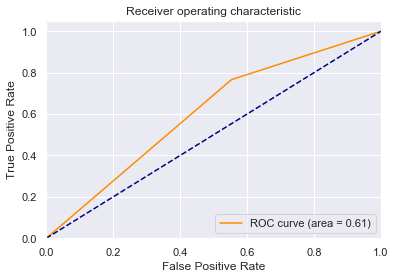

In [48]:
sqHinge_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_jobs=-1, penalty='l2')

cv = StratifiedShuffleSplit( n_splits=3,test_size=0.2)

iter_num = 1
scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    sqHinge_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = sqHinge_sgd.predict(scl.transform(X[test_idx]))
    result = getSummaryMetrics(y[test_idx], yhat, "Hinge with Scaler SGD",iter_num)
    test_result.append(result)
    iter_num+=1

**SVM SGD Conclusion** &nbsp;
Running the best SGD model (SVM with scaler) on 3-folds, 80-20 split yields consistent performance of 61% accuracy and ~62% RMSE.  As seen from the above results, the best model with the highest accuracy was still the traditional Logistric Regression.

The precision for the SGD Hinge model is lower, but was lower with accuracy.  The model did do a better job of not classifiying machines having malware as not have malware (recal score of .45).

In [ ]:
df_test_result = pd.DataFrame(test_result)
df_test_result
df_test_result = df_test_result[["shortDesc","test_num","accuracy","rocauc","mae","rmse"]]
df_test_result.to_csv("data/test_result.csv",index=False)

## MODEL ADVANTAGES

### Logistic Regression Advantages
When we developed our model, we decided to use domain knowledge in order to find the best accuracy.  The model, while not impressive, did perform better than if we tried to include all fields.  An advantages of this model is the ability to calculate amount of categorical variables (95% of features) resulting in over 3,000 one-hot encoding.  Since Logistic Regression is incredible efficient using the odds ratio calculation, we are able to train and test our model on the full dataset, including reviewing interpretation of weights.  On average the accuracy was 0.619 from a 3-folds CV.

### Support Vector Machine Advantages
SVM model can measure optimum distance in order to determine the maximum margin of separation of classification in the dataset, while effective it is very inefficient.  Given our data has 300k rows and over 3000k One-Hot encoding, this model took over 18 hours to run.  We decided to use Stochastic Gradient Descent in order to train our dataset.  The performance is attained by allowing the maximum margins to randomly selecting sub samples for calculations instead of trying to calculate the distance using Linear SVM.  Using SGD, we are able to achieve similar performance as the Logistic Regression after we standardize the units of all our values.  A 3-folds CV test resulted in a average accuracy of 0.612.

### Verdict
For each measurement score the Logistic performed slightly better, however not significant enough to make one model better than the other.  Given the requirements of our lab is to help explain the most important features, we were able to achieve this with Logistic Regression.  In order to get similar results in a reasonable amount of time with SVM, we used the `SGDClassifier` using Hinge (linear SVM) and a standard scalar on all the values.

Below are the final results on average from the 3-fold Cross Validation.

In [21]:
df_test_result = pd.read_csv("data/test_result.csv")

df_test_result.groupby("shortDesc").agg({
    "accuracy":"mean",
    "rocauc":"mean",
    "mae":"mean",
    "rmse":"mean"
})

accuracy    rocauc       mae      rmse
shortDesc                                                    
Hinge with Scaler SGD  0.611835  0.605566  0.388165  0.623026
Logistic Model         0.619588  0.616446  0.380412  0.616775

Our final Cross Validation results also shows that we were about to perform each cross validation with consistency for both models.

In [22]:
display(df_test_result)

shortDesc  test_num  accuracy    rocauc       mae      rmse
0         Logistic Model         1  0.619333  0.616283  0.380667  0.616982
1         Logistic Model         2  0.619618  0.616269  0.380382  0.616751
2         Logistic Model         3  0.619813  0.616786  0.380187  0.616593
3  Hinge with Scaler SGD         1  0.614250  0.607951  0.385750  0.621088
4  Hinge with Scaler SGD         2  0.608626  0.602402  0.391374  0.625599
5  Hinge with Scaler SGD         3  0.612630  0.606344  0.387370  0.622391

#### Reference for the Metrics above:

- Accuracy = Accuracy of the True Positive and True Negative. The goal is higher accuracy.
$$Accuracy = \frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$$

- ROC AUC = Area Under Curve of Receiver Operating Characteristic. The goal is higher ROC AUC. 
 - The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 

- MAE = Mean Absolute Error. Average of vertical distance between predict and actual. The goal is lower MAE.

$$MAE=\frac{1}{N}\sum_{j=1}^n abs(\hat{y}-y)$$

- RMSE = Root Mean Square Error represents the square root fo the quadratic mean of the difference between predict and actual. The goal is lower RMSE.
$$RMSE = \sqrt{\sum_{j=1}^n \frac{(\hat{y}-y)^2}{N}}$$

## INTERPRET FEATURE IMPORTANCE
We have 3072 features over 12 categories.  In order to explain the best features, we split up the sections by each category.

In [8]:
final_lr_coef = pd.Series(final_lr_clf.coef_[0], index=x_labels)

In [9]:
def get_weights(df, columns, sort_by = "abs", top = -1):
    df = df.loc[columns].copy()
    df = pd.DataFrame({"Field":df.index,"coef":df.values})
    df['abs'] = np.absolute(df["coef"])
    df['e_coef'] = np.exp(df['coef'])
    weights = df.sort_values(by=[sort_by],ascending=False).reset_index(drop=True)
    del weights["abs"]
    if top > 0:
        return weights.head(top)
    return weights

#### AVProductsInstalled
The values *2*, *3*, *4*, and *5* are all negative, indicating that they are less likely to be susceptible to malware.  The value of *5* has the smallest value, thus the odds of being attacked by malware reduces by a factor of .37 holding all other features constant.

The value of *1* shows a weigth of .08, indicating a positive relationship to a machine having malware.  Through our EDA, we believe this field has a positve correlation to if an Antivirus in enabled or not.

Field      coef    e_coef
0  _5.0 -0.097230  0.907348
1  _4.0 -0.974952  0.377211
2  _3.0 -0.546193  0.579150
3  _2.0 -0.107799  0.897808
4  _1.0  0.082910  1.086444

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


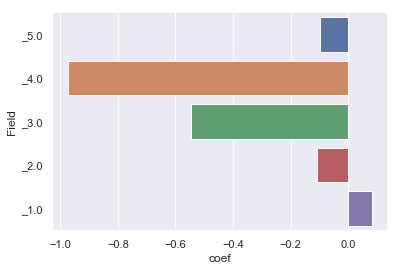

In [29]:
weights = get_weights(final_lr_coef, AVProductsInstalled.columns, sort_by="Field", top=100)
weights["Field"] = weights["Field"].str.slice(19)

display(weights)

sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
# fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### SmartScreen
The results from **SmartScreen** is rather interesting.  From our EDA, we learned that if **SmartScreen** is disabled (*Off*,*ExistsNotSet*) a machine was more likely to be infected by malware.  However, a machine is not increasing the liklyhood of being infected, instead decreasing their chance of not having malware.  The value *Warn*, which we through would be enabling Smart Screen has the smallest negative weight of -0.086.  We believe this helps our theory that users are more to blame about infections as opposed o the machine.

*RequieAdmin* has the best chance of not getting an infection with a weight of -0.63, or decreases by a factor of 0.53 holding all other features constanct.

Field      coef    e_coef
0          _Warn -0.085573  0.917986
1  _RequireAdmin -0.634587  0.530154
2        _Prompt -0.510671  0.600093
3           _Off -0.202693  0.816529
4  _ExistsNotSet  0.010071  1.010122
5         _Block -0.219810  0.802672

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


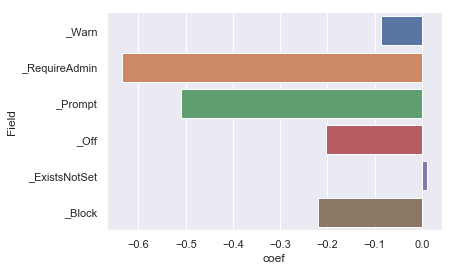

In [30]:
weights = get_weights(final_lr_coef, SmartScreen.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(11)

display(weights)

sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
# fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### AvSigVersion_x_x
Through domain knowledge we hyptohesis that having the latest definitions of malware for Defender reduces your chance having malware.  Through our discovery of the model, we learned this is the opposite.  Have the latest version increases yoru chance for a detection, by a factor of 1.06, 1.21, or 1.37 for the 3 latest version respectively (1.277,1.275, and 1.273).

Where as, holding back a couple versions gives users the best chance of not being attacked with a factor less then .8 for the next 4 versions.

Field      coef    e_coef
0   _1.277  0.026352  1.026702
1   _1.275  0.194731  1.214984
2   _1.273  0.315024  1.370292
3   _1.271 -0.371629  0.689610
4   _1.269 -0.304498  0.737494
5   _1.267 -0.270483  0.763011
6   _1.265 -0.231010  0.793731
7   _1.263 -0.293726  0.745481
8   _1.261 -0.026394  0.973952
9   _1.259 -0.144981  0.865038
10  _1.257 -0.071023  0.931441
11  _1.255  0.124570  1.132661
12  _1.253  0.117200  1.124344
13  _1.251 -0.111189  0.894770
14  _1.249 -0.101788  0.903221
15  _1.247 -0.000631  0.999369
16  _1.245 -0.057471  0.944149
17  _1.243 -0.057429  0.944189
18  _1.241 -0.184805  0.831266
19  _1.239  0.017581  1.017737
20  _1.237 -0.361724  0.696474
21  _1.235 -0.135368  0.873394
22  _1.233 -0.130251  0.877875
23  _1.231 -0.005651  0.994365
24  _1.229  0.103628  1.109188
25  _1.227 -0.150924  0.859913
26  _1.225  0.196246  1.216826
27  _1.223  0.057063  1.058722
28  _1.221  0.036875  1.037563
29  _1.219 -0.021071  0.979149
30  _1.217  0.073833  1.076627
31  _1.213  0.049838  1.051100
32  _1.207  0.002136  1.002138
33  _1.203 -0.019155  0.981027
34  _1.199  0.066226  1.068469
35    _0.0  0.026638  1.026996

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


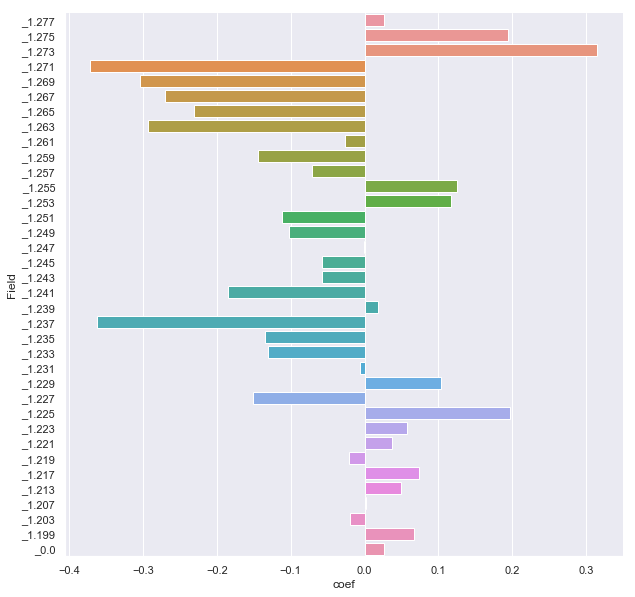

In [32]:
weights = get_weights(final_lr_coef, AvSigVersion_x_x.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(16)

display(weights)

sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### AppVersion_x_x
The **AppVersion** is showing similar results, indicating that having the latest build may not be a good idea if you want to prevent your machine from being attacked.  Versions *4.14* and *4.16* has similar weights of less then -0.70 giveing those versions the best chance to prevent the machine from malware.

Field      coef    e_coef
0    _4.9 -0.022486  0.977765
1    _4.8  0.105460  1.111222
2    _4.7 -0.038863  0.961883
3    _4.6 -0.034927  0.965676
4    _4.5 -0.110134  0.895714
5    _4.4  0.220013  1.246093
6   _4.18 -0.268320  0.764663
7   _4.17 -0.001866  0.998135
8   _4.16 -0.703922  0.494642
9   _4.15  0.000000  1.000000
10  _4.14 -0.774776  0.460807
11  _4.13 -0.010490  0.989565
12  _4.12 -0.094857  0.909503
13  _4.11 -0.056901  0.944688
14  _4.10  0.148804  1.160446

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


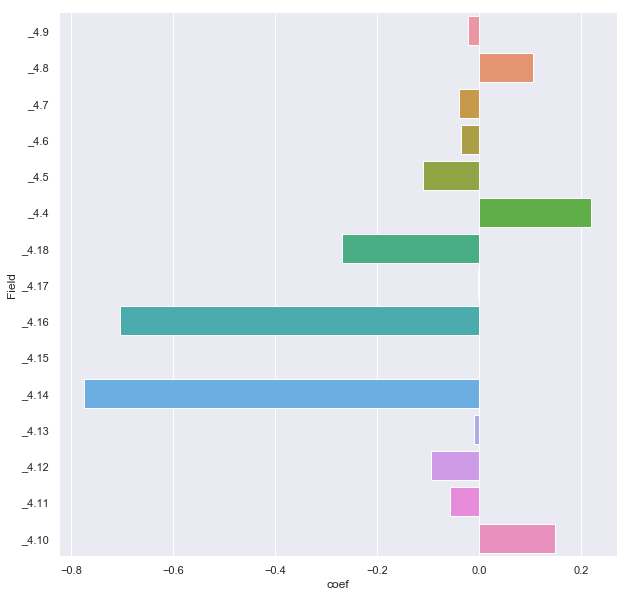

In [33]:
weights = get_weights(final_lr_coef, AppVersion_x_x.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(14)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### AVProductStatesIdentifier
In order to better understand what **AVProductStatesIdentifier** tells us, we created a lineplot to determine if the larger the value of the identifier the change in coefficients.  Visually, we are not able to see any evident or pattern for **AVProductStatesIdentifier**.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


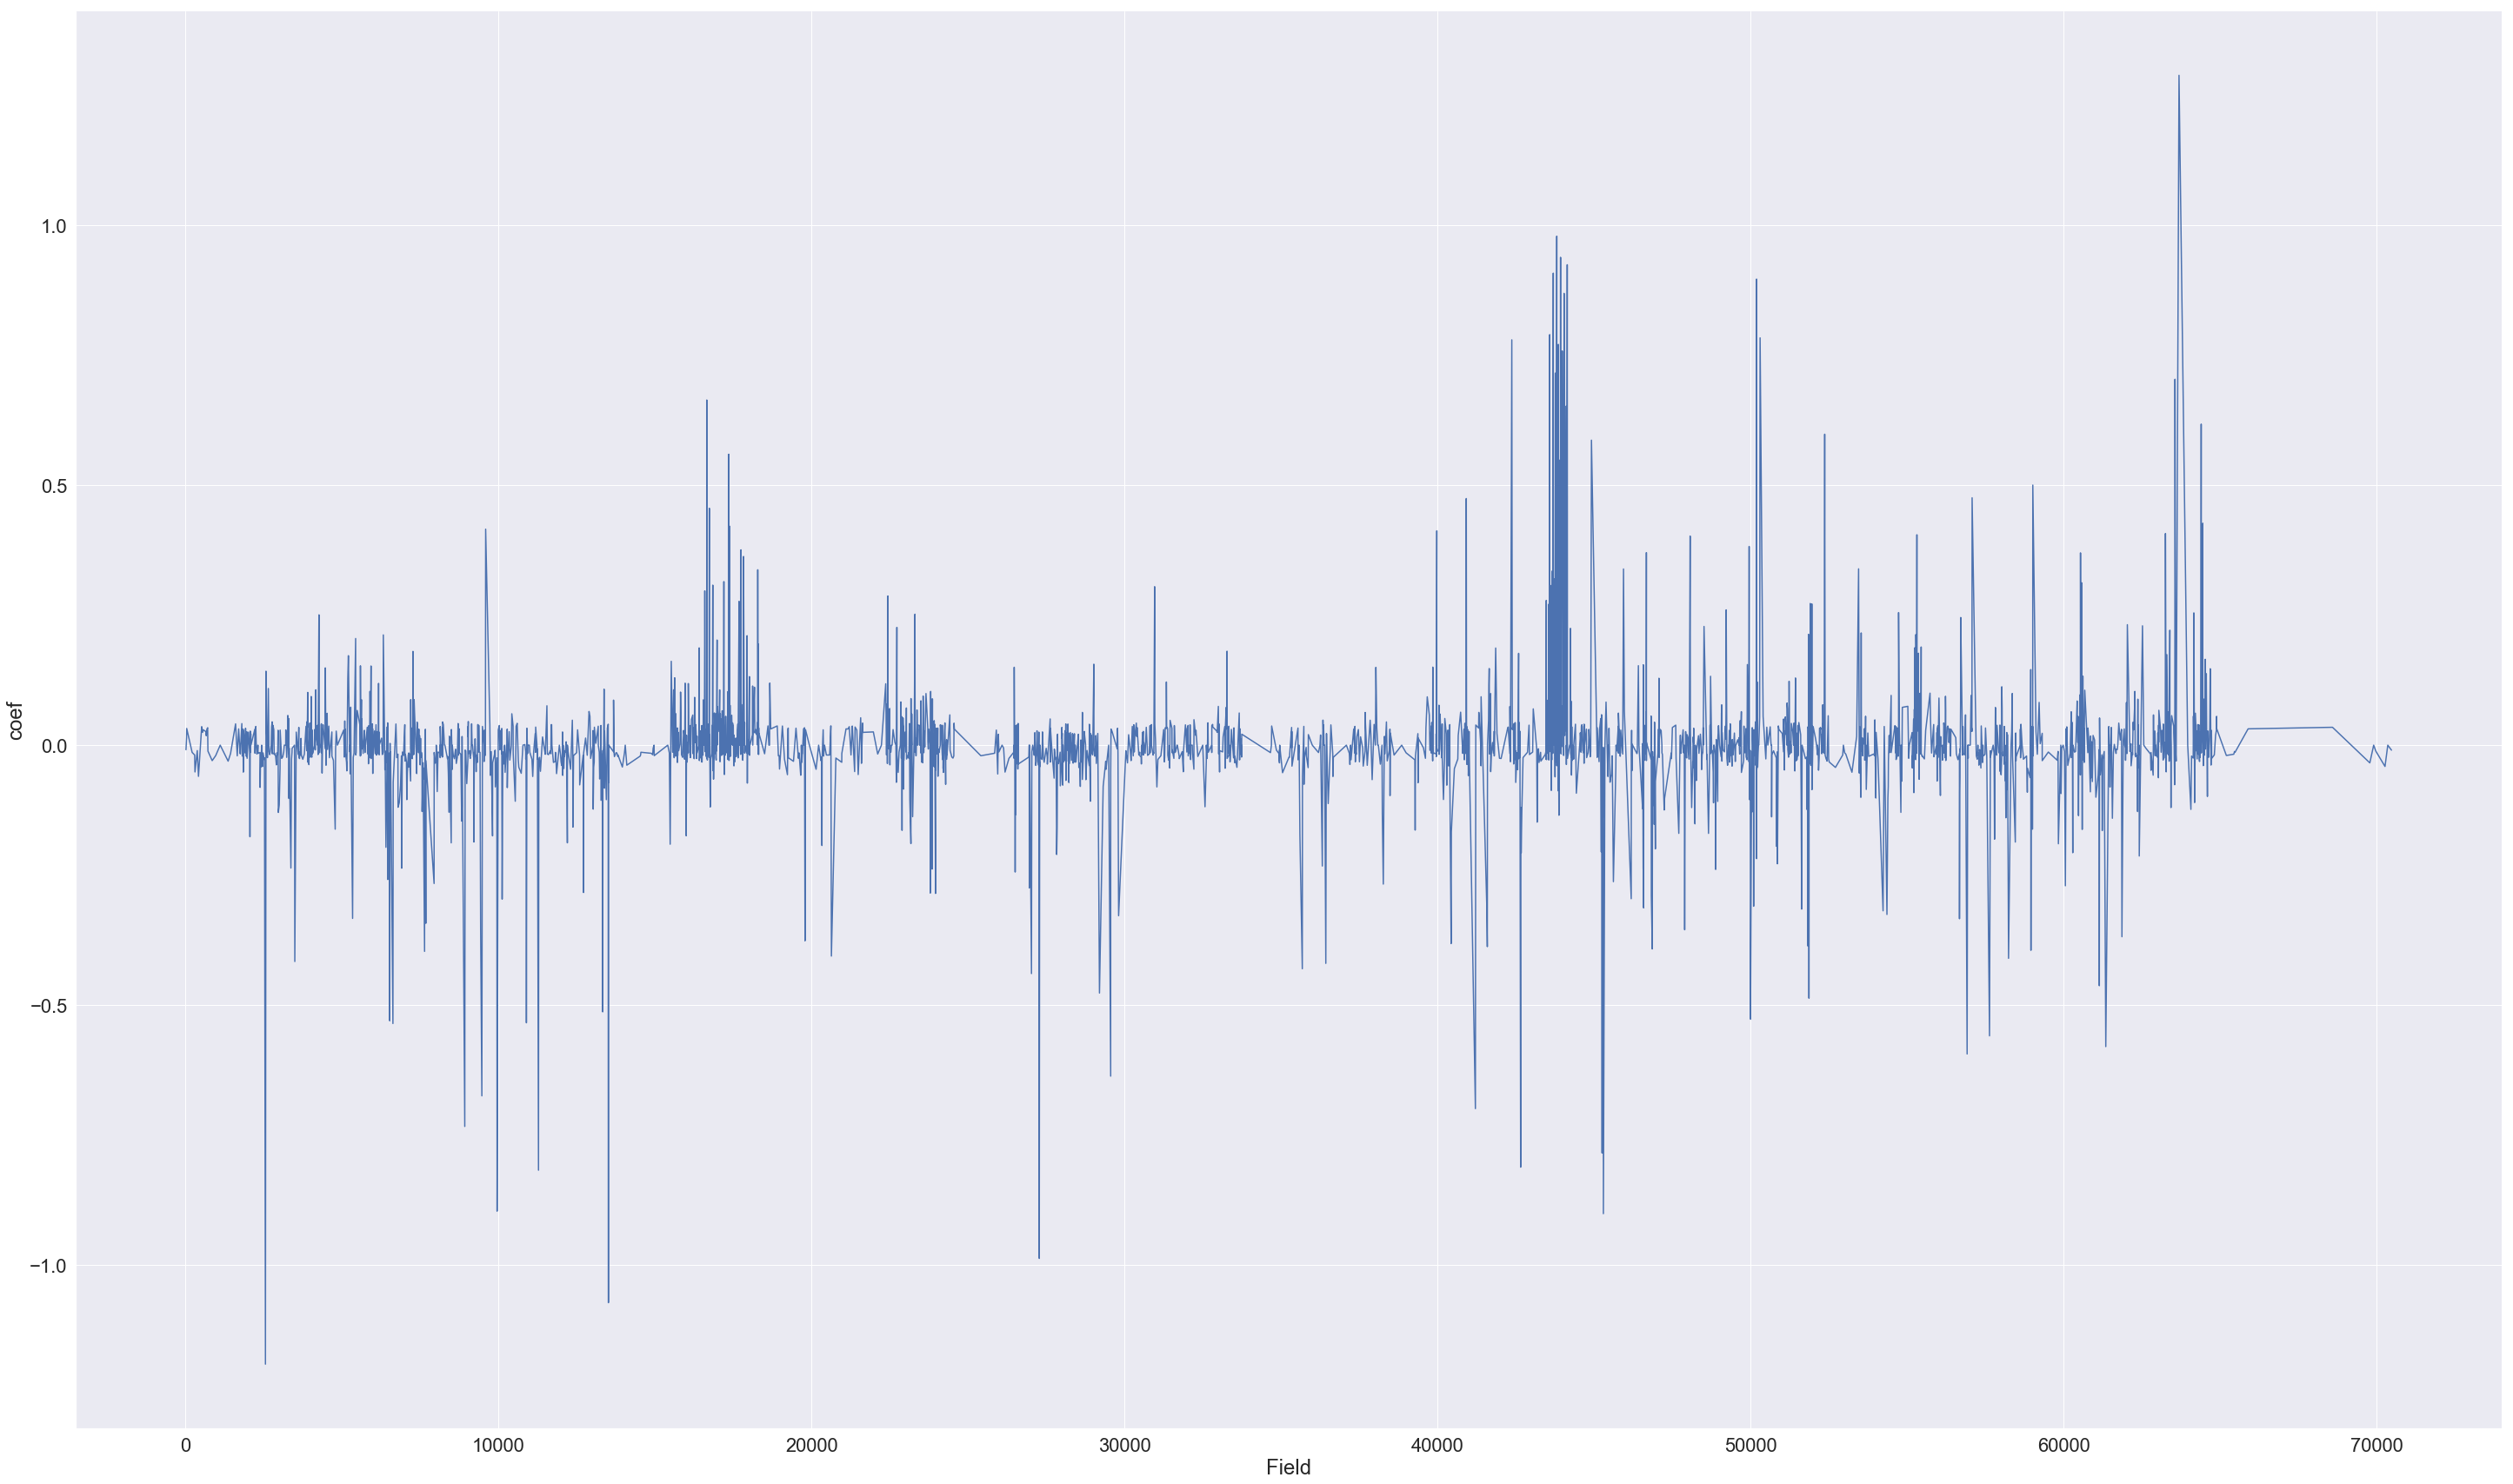

In [10]:
weights = get_weights(final_lr_coef, AVProductStatesIdentifier.columns)
weights["Field"] = weights["Field"].str.slice(26)
weights["Field"] = weights["Field"].astype(float)
weights = weights.sort_values(by=["Field"],ascending=True).reset_index(drop=True)

# weights["Field"] = "_" + weights["Field"].astype(str)

sns.set_style('ticks')
sns.set(font_scale=2)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(50, 30)
# sns.barplot(x=weights["coef"], y=weights["Field"])
sns.lineplot(x=weights["Field"], y=weights["coef"], ax = ax)
sns.despine()
fig.show()

#### Census_MDC2FormFactor
Tablets are least likely to be have malware infections with *SmallTablet* have a weight of -1.02.  In otherwords, the odds of a machine identified as a Small Tablet having malwre reduces by a factor or .36.  The other tables also have a negative weight.  There is also a trend on Servers, all being negative weights.

It appears that personal computers, i.e. otebook or PC has the highest chance of being detected for malware.  This appears alligned with our EDA, that personal settings has the biggest impact if a user is suspectible to malware.

Field      coef    e_coef
0    SmallTablet -1.018240  0.361230
1    SmallServer -0.493269  0.610627
2        PCOther  0.115360  1.122277
3       Notebook  0.163409  1.177519
4   MediumServer -0.076262  0.926574
5    LargeTablet -0.557434  0.572677
6    LargeServer -0.174758  0.839660
7     Detachable -0.145024  0.865001
8        Desktop  0.174169  1.190257
9    Convertible  0.110885  1.117267
10      AllInOne  0.257899  1.294209

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


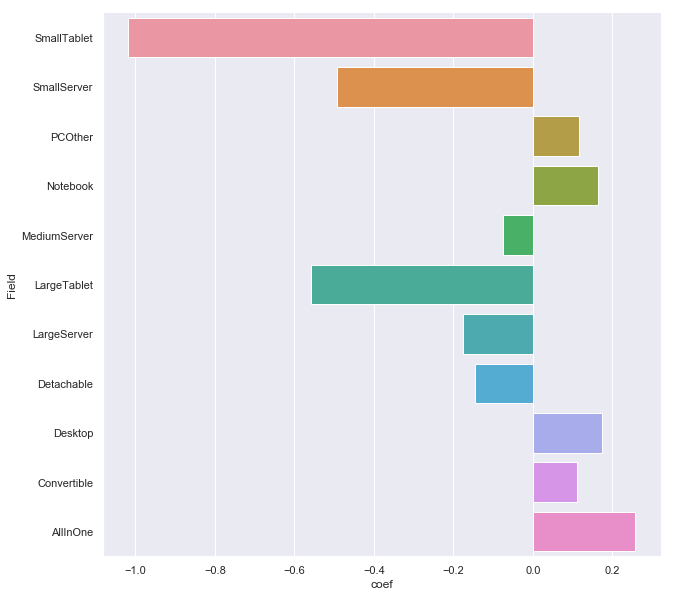

In [12]:
weights = get_weights(final_lr_coef, Census_MDC2FormFactor.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(22)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### Census_OSSkuName
All the entriprise versions of Windows 10 has the highest weights for being suspectible to malware.  The highest being *Enterprise_S* with a odds of having malware dections increase by a factor of 1.32.  Education and Server editions lead the versions types as being the less suspectible to viruses.



Field      coef    e_coef
0                     UNLICENSED -0.012612  0.987467
1                STANDARD_SERVER -0.059130  0.942585
2     STANDARD_EVALUATION_SERVER -0.390662  0.676608
3             SB_SOLUTION_SERVER -0.232059  0.792899
4              PRO_WORKSTATION_N  0.020471  1.020682
5                PRO_WORKSTATION  0.017506  1.017660
6                 PROFESSIONAL_N -0.052881  0.948493
7                   PROFESSIONAL -0.167975  0.845375
8                 ENTERPRISE_S_N  0.033134  1.033689
9                   ENTERPRISE_S  0.283321  1.327532
10                  ENTERPRISE_N -0.039203  0.961556
11                    ENTERPRISE  0.147140  1.158516
12                   EDUCATION_N  0.029435  1.029873
13                     EDUCATION -0.470446  0.624723
14             DATACENTER_SERVER  0.000000  1.000000
15  DATACENTER_EVALUATION_SERVER  0.005119  1.005132
16           CORE_SINGLELANGUAGE -0.051395  0.949903
17                        CORE_N -0.247499  0.780751
18          CORE_COUNTRYSPECIFIC -0.136664  0.872264
19                          CORE -0.147111  0.863198
20                        CLOUDN  0.019070  1.019253
21                         CLOUD -0.190823  0.826279

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


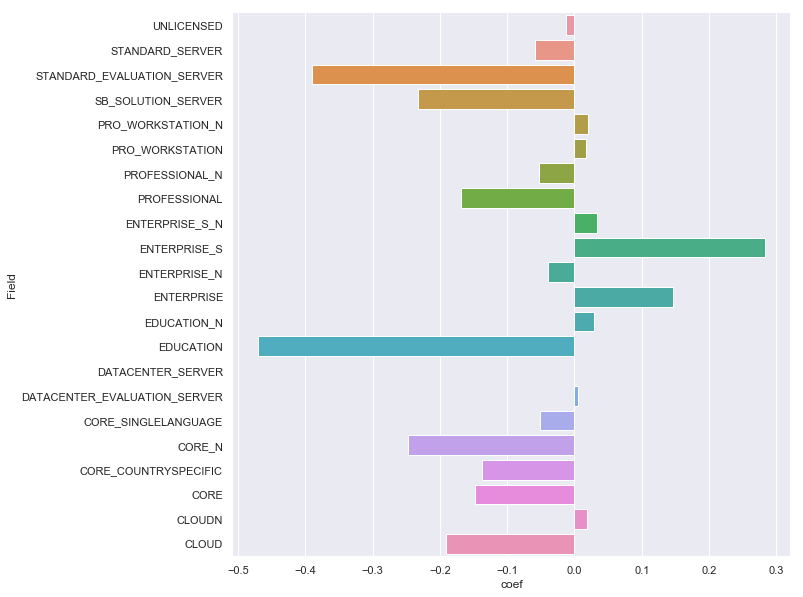

In [14]:
weights = get_weights(final_lr_coef, Census_OSSkuName.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(17)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### Census_GenuineStateName
All the values has a negative impact on the model.  The license is *Unkown* that has the highest weight in our model.  Given this feature is pull the odds in the same direction, we are not sure how viable it is in our entire model.

Field      coef    e_coef
0          UNKNOWN -0.909780  0.402613
1          OFFLINE -0.240184  0.786483
2       IS_GENUINE -0.029345  0.971081
3  INVALID_LICENSE -0.463953  0.628793

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


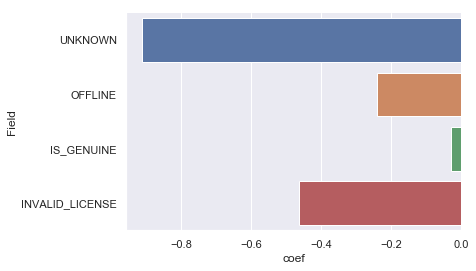

In [17]:
weights = get_weights(final_lr_coef, Census_GenuineStateName.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(24)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
# fig.set_size_inches(10, 10)
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### Census_ActivationChannel
When the machine's activation channel was performed through *VolumeMAK* it has the lowest chance for malware.  The odds of a machine having a dection reduces by a factor of 0.466 holding all other features constant.  All the other featurers are negative as well with *Retail* stayign close to 0.

Field      coef    e_coef
0      Volume:MAK -0.763570  0.466000
1     Volume:GVLK -0.332604  0.717054
2  Retail:TB:Eval -0.359739  0.697858
3          Retail -0.043652  0.957287
4      OEM:NONSLP -0.024601  0.975699
5          OEM:DM -0.119097  0.887721

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


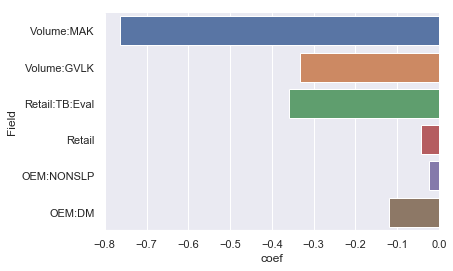

In [18]:
weights = get_weights(final_lr_coef, Census_ActivationChannel.columns, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(25)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

#### Continous Variables
**Cenus_TotalPhysicalRAM** has the highest likklyhood of being suspetible by an attack.  The weight of 0.165 is related to each megabyte of memory.  Hard Drive Capacity is also measured by a single megabyte.  We do see that the increase in core counts can reduce the chance of an attack, however from EDA the highest cores are related to Servers.

Field      coef    e_coef
0                            TotalPhysicalRAM  0.165807  1.180345
1                   SystemVolumeTotalCapacity  0.023998  1.024289
2                          ProcessorCoreCount -0.026030  0.974306
3                    PrimaryDiskTotalCapacity  0.041287  1.042151
4    InternalPrimaryDisplayResolutionVertical -0.000795  0.999205
5  InternalPrimaryDisplayResolutionHorizontal  0.000269  1.000269
6  InternalPrimaryDiagonalDisplaySizeInInches  0.001210  1.001210

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


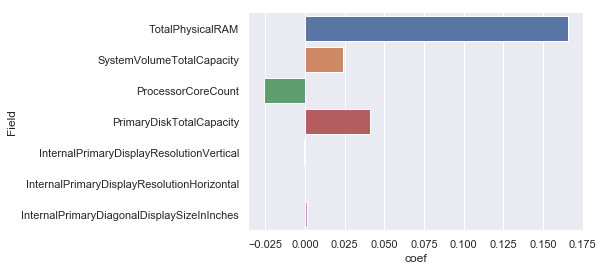

In [21]:
weights = get_weights(final_lr_coef, cols_numerical, sort_by="Field")
weights["Field"] = weights["Field"].str.slice(7)
display(weights)
sns.set_style('ticks')
sns.set(font_scale=1)
fig, ax = plt.subplots()
sns.barplot(x=weights["coef"], y=weights["Field"])
sns.despine()
fig.show()

## INTERPRET SUPPORT VECTOR

In order to interpret the performance of SVM, we created a sub sample set of about 1% of the data.  We will use the Linear SVM to create our weights.  We also wanted to see how different costs can change the performance of SVM with our smaller data set.

In [91]:
# Run Setup 
# Loads Finalized Data Set

# #DF
df = pd.concat(
    (
        AVProductStatesIdentifier,
        AVProductsInstalled,
        SmartScreen,
        AvSigVersion_x_x,
        AppVersion_x_x
    ),axis=1)

# # Get DF1
df1 = pd.concat(
    (
        df,
        Census_MDC2FormFactor,
        Census_OSSkuName,
        Census_GenuineStateName,
        Census_ActivationChannel
    ),axis=1)

df_continous = final[cols_numerical].copy()
df_continous["Census_SystemVolumeTotalCapacity"] = np.log(df_continous.Census_SystemVolumeTotalCapacity)
df_continous["Census_TotalPhysicalRAM"] = np.log(df_continous.Census_TotalPhysicalRAM)
df_continous["Census_PrimaryDiskTotalCapacity"] = np.log(df_continous.Census_PrimaryDiskTotalCapacity)


df_all = pd.concat(
    (
        df1,
        df_continous
    ),axis=1)

y_all = final["HasDetections"]

# select sample data 1 = 1%
k=1 

XX=df_all.sample(frac=k/100, replace=False, random_state=1)

yy = y_all[XX.index]

X=XX.values
y=yy.values

print ("Sample dataset, size" ,k,"% ", (X.shape),(y.shape))
    

Sample dataset, size 1 %  (3334, 3072) (3334,)


In [94]:
#    Let split the sample data set into training and testing splits

num_cv_iterations = 1
num_instances = len(y_sample)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

for train_indices, test_indices in cv_object.split(X,y): 

    X_train1 = X_sample[train_indices]
    y_train1 = y_sample[train_indices]
    
    X_test1 = X_sample[test_indices]
    y_test1 = y_sample[test_indices]
    
#print(cv_object)

### Cost Optimization
Our above model on the smaller data set returns an accuracy of 0.57.  In order to tune our model we changed the cost parameter of the linear SVM between the ranges of 0.1 and 1.

In [7]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC

split_num=5
C_range=list(np.linspace(0.1,1,split_num))
acc_score=[]
scorr={} # dictionary to save c with score
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X_train, y_train, cv=3, scoring='accuracy')
    acc_score.append(scores.mean())
    scorr[c] = scores.mean() #create dicitionary

print(acc_score)  

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0.608535102638438, 0.6059121178027663, 0.5980364111789398, 0.5995391822605837, 0.6051626366321581]


0.608535102638438

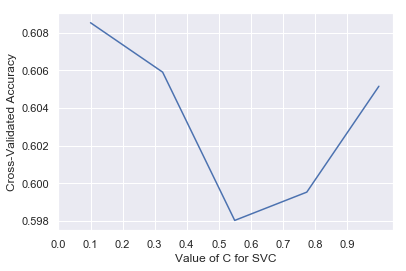

In [8]:
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C_values=list(np.linspace(0.1,1,split_num))
sns.set(font_scale=1)
plt.plot(C_values,acc_score)
plt.xticks(np.arange(0,1,0.1))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')
max(acc_score)

From our cost analysis, we see that the **cost setting of 0.1** performs the best.  <br><br> **Below is the final model used to help provide interpretations of our weights.**

In [68]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=max(scorr, key=scorr.get), kernel='linear') # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.5712143928035982
[[179 160]
 [126 202]]


In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_error = sqrt(mean_squared_error(y_test, y_hat))
print("root_mean_squared_error = ", rmse_error)

root_mean_squared_error =  0.6548172319024613


In [71]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(1783, 3072)
(1783,)
[891 892]


### Let's plot SVM vectors and analyze top 10 

Top 10 Features
SmartScreen_ExistsNotSet             0.889772
AVProductStatesIdentifier_43856.0    0.800000
Census_MDC2FormFactor_LargeTablet    0.643834
AvSigVersion_x_x_1.273               0.637651
AVProductStatesIdentifier_53447.0    0.623201
AVProductStatesIdentifier_46669.0    0.590287
AppVersion_x_x_4.14                  0.571275
AVProductStatesIdentifier_41571.0    0.562989
Census_GenuineStateName_OFFLINE      0.554085
AVProductsInstalled_3.0              0.517236
dtype: float64


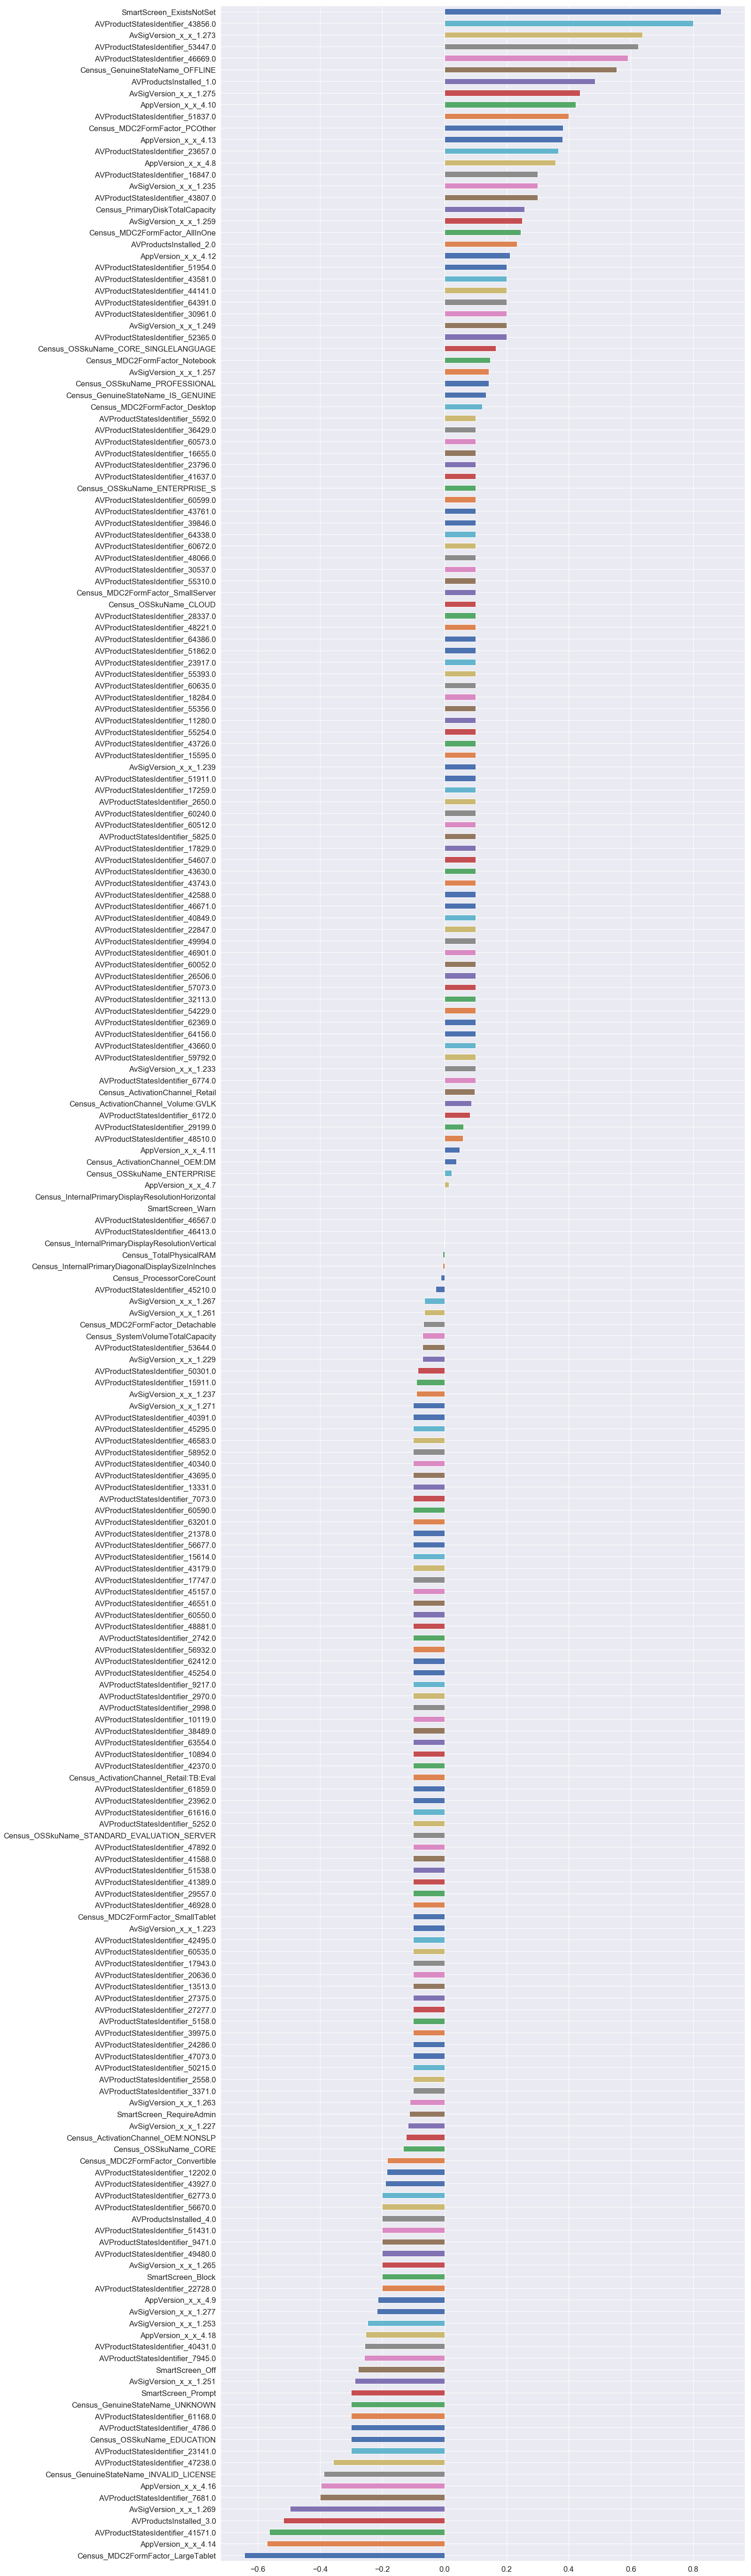

In [77]:
weights = pd.Series(svm_clf.coef_[0],index=XX.columns)
weights=weights.sort_values(ascending=True)
weights=weights[(weights.values!=0)]

sns.set(font_scale=1.5)
plt.figure(figsize=(20,100))
weights.sort_values(ascending=True).plot(kind='barh')
print ("Top 10 Features")
top_w=weights.abs().sort_values(ascending=False).head(10)
print (top_w)

From SVM vector weight analysis, positive weight have higher correlation with "HasDetection" class 1 and negative weight correlates with class 0 or no detection for Malware.

## Interpreting Features Importance on SVM
We analyzed SVM vectors for the important features from the features identified that has the most weight, negative and positive. For this task, we plot the most 6 positive and 4 negative feature weight. We compare the SVM vectors to its original vectors. SVM vectors are expected to lie on the edge of the boundaries between Malware detections so we are expecting the separation between the two to be much closer in comparison to the original vectors. We can conclude that features that show this behavior confirm the importance of the features in SVM model.

Based on the SVM vector analysis in comparison to the original vectors, the followings are our conclusions:<br>
1) Positive Correlation, i.e., machines with these features enabled tend to have Malware detected:
- SmartScreen_ExistNotSet.
- AvProductStateIdentifier_53447
- AvProductStateIdentifier_46669 
- AvProductStateIdentifier_43856
- GenuineStateName_Offline. 
- AvSigVersion_1.273


2) Negative Correlation, i.e., machines with these features enabled tend to be free of Malware:
- FormFactor_LargeTablet
- AppVersion 4.14
- AvProductStateIdentifier_41571
- AvProductInstalled3.0

Interestingly, some of the features that identified as SVM vectors are also identified as feature importance in the Logit feature importance analysis:
- SmartScreen_ExistNotSet
- AvSigVersion_1.273
- FormFactor_LargeTablet
- AppVersion 4.14

ColumnArrays.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # "SMode",


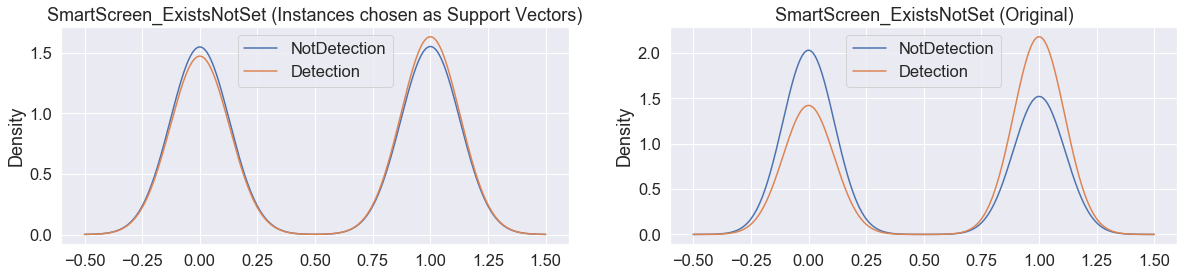

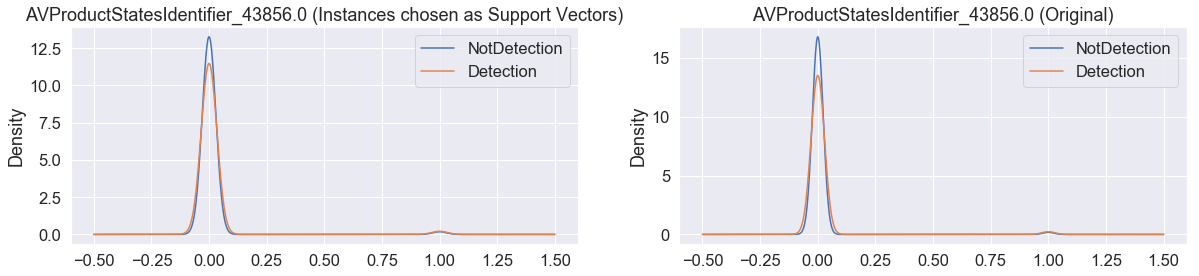

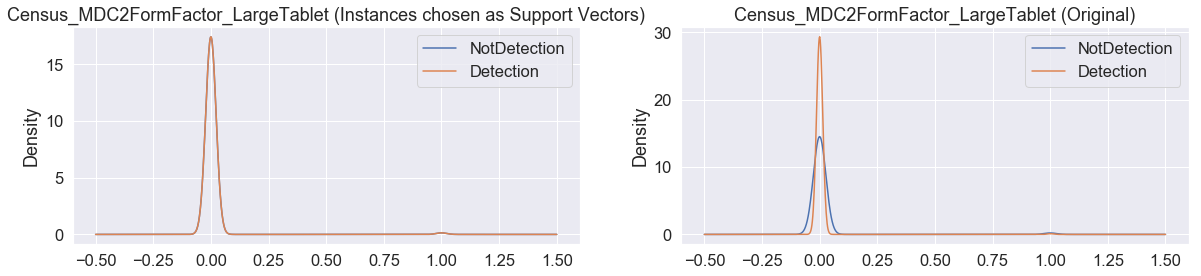

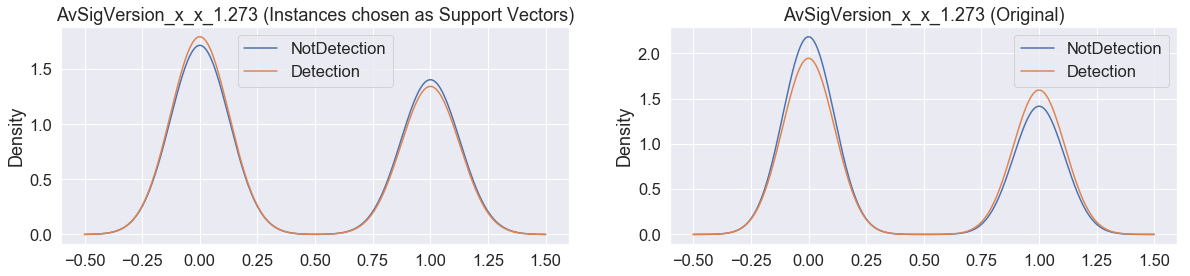

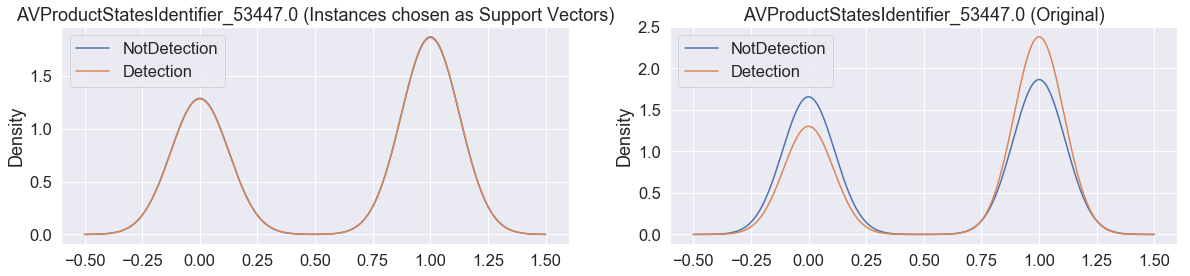

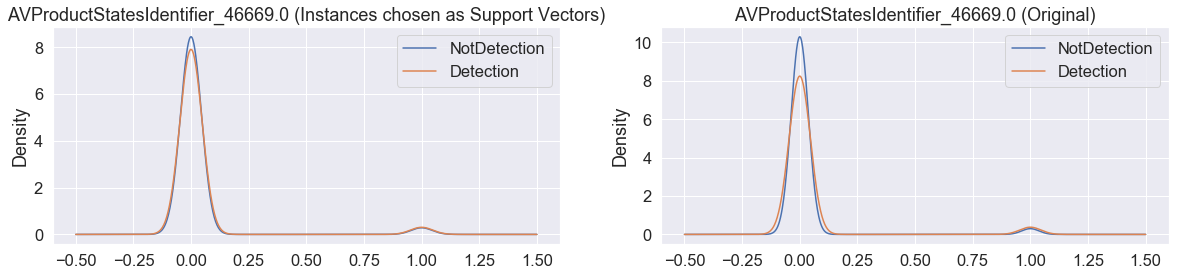

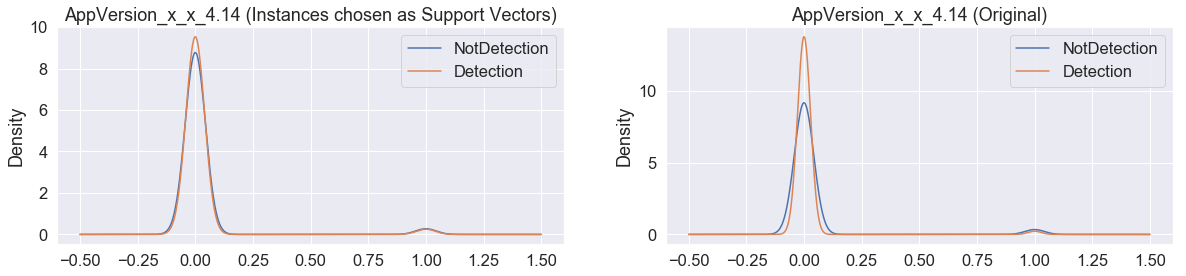

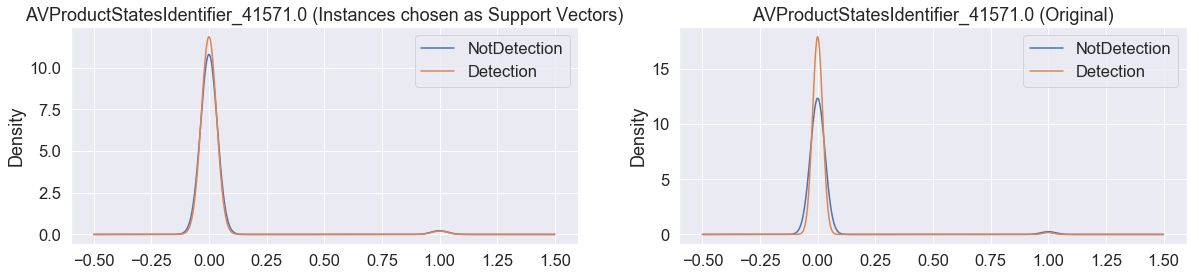

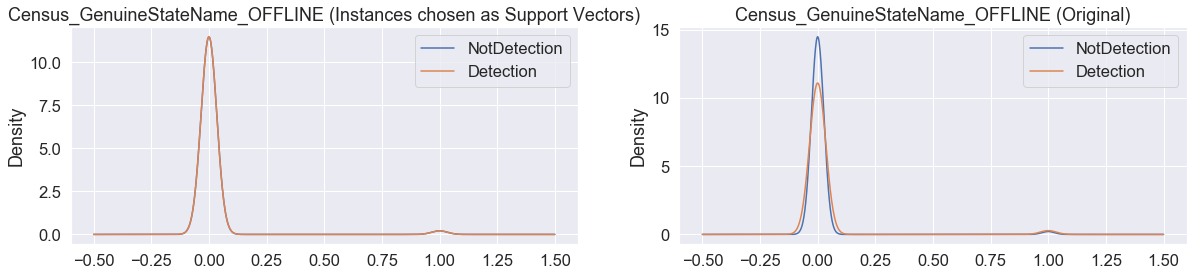

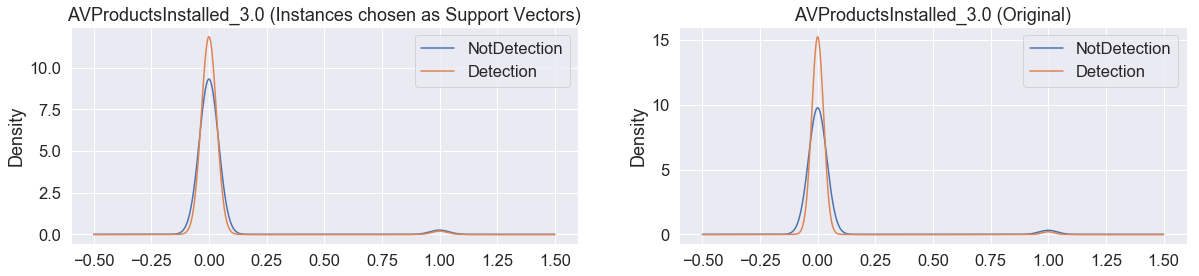

In [96]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# make a dataframe of the training data

df_tested_on = XX.iloc[train_indices] 
df_support = df_tested_on.iloc[svm_clf.support_,:]
df_support['HasDetections'] = y_sample[svm_clf.support_] 
XX['HasDetections'] = y_sample

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['HasDetections']) # SVM
df_grouped = XX.groupby(['HasDetections'])  #original data

# plot KDE of Different variables
vars_to_plot = top_w.index
vars_to_plot
for v in vars_to_plot:
    plt.figure(figsize=(20,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['NotDetection','Detection'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['NotDetection','Detection'])
    plt.title(v+' (Original)')
